In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_validate
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import catboost as cat
import ipywidgets
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import shap
import statsmodels.api as sm




In [13]:
# Funciones para transformación de caracteristicas

# Función para eliminar variables que no aportan valor
def drop_list(dataset, delete_list):
    return dataset.drop(delete_list, axis=1)


# Transformar variables NA Booleanas en 0
def transform_bool(dataset, swap_list):
    for i in swap_list:
        dataset[i] = dataset[i].fillna(0)
    return dataset

# Transformar 'year_built' en categórica
def transform_year_built(year_built):
    if pd.isna(year_built) or year_built < 0:
        return "Unknown"
    elif year_built < 40:
        return "0 - 40"
    elif year_built < 70:
        return "40 - 70"
    elif year_built < 120:
        return "70 - 120"
    elif year_built < 150:
        return "120 - 150"
    else:
        return "+150"

# Transformar valores NA en 'unknown' en categóricas
def transform_na(dataset, swap_list):
    for i in swap_list:
        dataset[i] = dataset[i].fillna('unknown')
    return dataset


# Función para transformar valores NA en 0 para variables numéricas
def transform_num(dataset, num_list):
    for i in num_list:
        dataset[i] = dataset[i].fillna(0)
    return dataset

# Crear variables ratio
def create_ratio_variables(df):
    df['rooms_per_sqm'] = df['rooms'] * 100 / (df['sq_meters_built'] + 1)
    df['bathrooms_per_sqm'] = df['bathrooms'] * 100 / (df['sq_meters_built'] + 1)
    df.drop(['rooms', 'bathrooms'], axis=1, inplace=True)
    return df

# Función para filtrar por rango de precios y tipo de propiedad 'piso'
def filter_price(dataset, min_price, max_price):
    processed_data = dataset[(dataset['price'] >= min_price) &
                             (dataset['price'] <= max_price) &
                             (dataset['property_type'] == 'piso')]

    # Eliminar la columna 'property_type' ya que todas las propiedades son 'piso'
    processed_data = processed_data.drop(columns=['property_type'])

    return processed_data

# Función general
def transform_dataset(dataset):
    # Variables a eliminar
    delete_list = ['id', 'currency', 'latitude', 'longitude', 'floor', 'sq_meters', 'quality',
                   'city', 'furniture', 'garage', 'garden', 'closest_station', 'heating',
                   'created_at', 'last_seen', 'doorman']

    #  Variables boleanas con valores NA a transformar
    bool_list = ['balcony', 'terrace', 'exterior', 'rooftop', 'elevator', 'pool', 'ac']

    # Variables cat con valores NA a transformar
    cat_list = ['orientation', 'neighborhood', 'property_type']

    # Variabeles númericas a transformar
    num_list = ['sq_meters_built', 'rooms', 'bathrooms']

    # Eliminar variables que no aportan información
    dataset = drop_list(dataset, delete_list)

    # Transformar variables booleanas NA en 0
    dataset = transform_bool(dataset, bool_list)

    # Transformar la columna 'year_built' en el número de años desde su construcción
    dataset['year_built'] = 2025 - dataset['year_built']

    # Función para transformar 'year_built' en categórica
    dataset['year_built'] = dataset['year_built'].apply(transform_year_built)

    # Transformar valores nulos como categória 'unknown'
    dataset = transform_na(dataset, cat_list)

    # Transformar valores nulos numéricos NA en 0
    dataset = transform_num(dataset, num_list)

    # Crear variables de ratio
    dataset = create_ratio_variables(dataset)

    # Filtrar por rango de precios
    dataset = filter_price(dataset, min_price=60000, max_price=180000)

    return dataset

## Análisis exploratorio

In [14]:
sales_data = pd.read_csv('processed_sale_Barcelona.csv', delimiter = ',')
sales_data.head()

,id,price,currency,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,...,neighborhood,dist_city_center,furniture,garage,property_type,garden,closest_station,dist_closest_station,created_at,last_seen
0,320294,150000,€,41.459649,2.174793,63.0,67,3,1,NaN,...,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,NaN,NaN,piso,NaN,Ciutat Meridiana,0.121438,9/3/2021 10:16,11/12/2021 13:50
1,1786997,150000,€,41.422081,2.155370,48.0,52,2,1,NaN,...,El Carmel,3.991000,NaN,NaN,piso,NaN,El Carmel,0.277336,9/3/2021 10:16,11/12/2021 13:50
2,1787143,395000,€,41.402928,2.207851,84.0,91,2,2,NaN,...,El Poblenou,3.579261,NaN,NaN,duplex,NaN,Poblenou,0.383878,8/30/2021 12:17,8/30/2021 12:17
3,1976767,540000,€,41.394692,2.144422,NaN,100,3,1,NaN,...,Sant Gervasi - Galvany,2.257852,NaN,1.0,piso,NaN,Hospital Clínic,0.875652,9/1/2021 14:04,9/2/2021 13:50
4,27972575,650000,€,41.398971,2.120754,NaN,141,3,2,NaN,...,Sarrià,4.283368,NaN,1.0,piso,NaN,Maria Cristina,1.310073,8/29/2021 11:47,9/2/2021 11:01


In [15]:
# Valores nulos
sales_data.isnull().sum()

id                         0
price                      0
currency                   0
latitude                   0
longitude                  0
sq_meters               2573
sq_meters_built            0
rooms                      0
bathrooms                  0
balcony                 3637
terrace                 4419
exterior                1077
orientation             2713
floor                   2082
rooftop                 5440
elevator                 571
doorman                 5847
pool                    5677
ac                      3198
heating                 2490
year_built              1765
quality                    0
city                       0
neighborhood               0
dist_city_center           0
furniture               5847
garage                  5442
property_type              2
garden                  5786
closest_station            0
dist_closest_station       0
created_at                 0
last_seen                  0
dtype: int64

se aprecia como las variables sq_meters, balcon,terrace, exterior, orientation, floor, rooftop, elevator, doorman, pool, ac, heating, year_built, furniture, property_type y garden tienen valores nulos.

# Transformación de datos

In [16]:
# Lista variables a eliminar
delete_list = ['id', 'currency', 'latitude', 'longitude', 'floor', 'sq_meters', 'heating', 'quality',
        'city', 'furniture', 'garage', 'garden', 'closest_station',
        'created_at', 'last_seen', 'doorman']

sales_data = drop_list(sales_data, delete_list)

In [17]:
# Tratar con los valores nulos
sales_data.isnull().sum()

price                      0
sq_meters_built            0
rooms                      0
bathrooms                  0
balcony                 3637
terrace                 4419
exterior                1077
orientation             2713
rooftop                 5440
elevator                 571
pool                    5677
ac                      3198
year_built              1765
neighborhood               0
dist_city_center           0
property_type              2
dist_closest_station       0
dtype: int64

In [18]:
# Lista variables bolean con NA
bool_list = ['balcony', 'terrace', 'exterior', 'rooftop', 'elevator', 'pool', 'ac']

# Lista variables categoricas con NA
cat_list = ['orientation', 'neighborhood', 'property_type']

# Transformar variables NA booleanas a 0
sales_data = transform_bool(sales_data, bool_list)

# Transformar variables en unknown
sales_data = transform_na(sales_data, cat_list)



In [19]:
# Tratar con los valores nulos
sales_data.isnull().sum()

price                      0
sq_meters_built            0
rooms                      0
bathrooms                  0
balcony                    0
terrace                    0
exterior                   0
orientation                0
rooftop                    0
elevator                   0
pool                       0
ac                         0
year_built              1765
neighborhood               0
dist_city_center           0
property_type              0
dist_closest_station       0
dtype: int64

Se aprecia que solo la variable year_built queda con nulos. 

In [20]:
# Transformar 'year_built' en edad construcción
sales_data['year_built'] = 2025 - sales_data['year_built']

# Transformar en categórica
sales_data['year_built'] = sales_data['year_built'].apply(transform_year_built)

## Análisis descriptivo

In [21]:
# Visualización del dataset
sales_data.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,rooftop,elevator,pool,ac,year_built,neighborhood,dist_city_center,property_type,dist_closest_station
0,150000,67,3,1,0.0,1.0,1.0,este,0.0,0.0,0.0,1.0,Unknown,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,piso,0.121438
1,150000,52,2,1,0.0,0.0,1.0,unknown,0.0,0.0,0.0,1.0,Unknown,El Carmel,3.991000,piso,0.277336
2,395000,91,2,2,0.0,0.0,1.0,unknown,0.0,0.0,0.0,1.0,Unknown,El Poblenou,3.579261,duplex,0.383878
3,540000,100,3,1,0.0,0.0,1.0,sur,0.0,1.0,0.0,1.0,Unknown,Sant Gervasi - Galvany,2.257852,piso,0.875652
4,650000,141,3,2,0.0,0.0,1.0,este,0.0,1.0,0.0,1.0,Unknown,Sarrià,4.283368,piso,1.310073


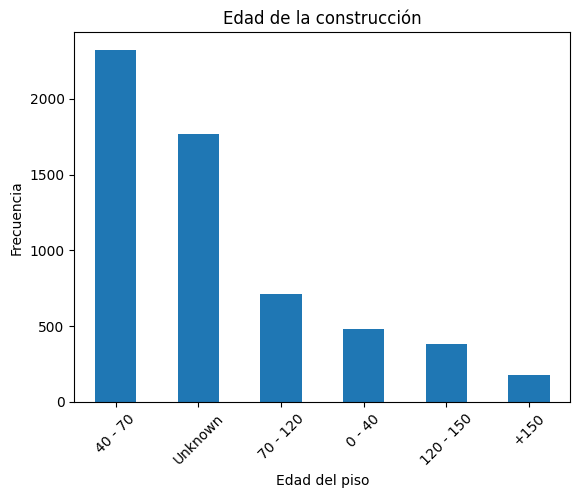

In [22]:
sales_data['year_built'].value_counts().plot(kind='bar')
plt.xlabel('Edad del piso')
plt.ylabel('Frecuencia')
plt.title('Edad de la construcción')
plt.xticks(rotation=45)
plt.show()

Observamos que la mayoría de los pisos clasificados tienen entre 40 y 70 años. Tambien destacar una gran cantidad de unknowns que es la siguiente clasificación.

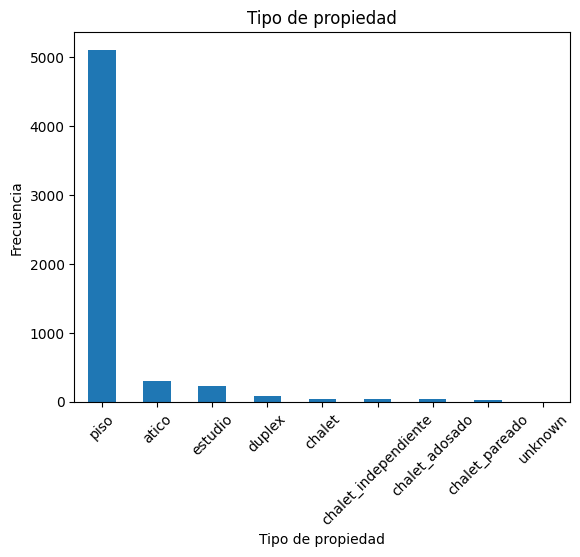

In [23]:
# Gráfica de barras para ver la distribución según categoría
sales_data['property_type'].value_counts().plot(kind='bar')
plt.xlabel('Tipo de propiedad')
plt.ylabel('Frecuencia')
plt.title('Tipo de propiedad')
plt.xticks(rotation=45)
plt.show()

Teniendo en cuenta que la mayoria de las propiedades son pisos, se optara por centrarse en esta tipologia de habitaje dado que lods aticos, duplex o chalets podrian contaminar las predicciones alejandose demasiado de los precios estandares de un piso.

In [24]:
# Filtrar solo por pisos
sales_data = sales_data[sales_data['property_type'] == 'piso']

# Eliminar columna property
sales_data = sales_data.drop(columns=['property_type'])
sales_data.head()

,price,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,rooftop,elevator,pool,ac,year_built,neighborhood,dist_city_center,dist_closest_station
0,150000,67,3,1,0.0,1.0,1.0,este,0.0,0.0,0.0,1.0,Unknown,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,0.121438
1,150000,52,2,1,0.0,0.0,1.0,unknown,0.0,0.0,0.0,1.0,Unknown,El Carmel,3.991000,0.277336
3,540000,100,3,1,0.0,0.0,1.0,sur,0.0,1.0,0.0,1.0,Unknown,Sant Gervasi - Galvany,2.257852,0.875652
4,650000,141,3,2,0.0,0.0,1.0,este,0.0,1.0,0.0,1.0,Unknown,Sarrià,4.283368,1.310073
5,128500,48,2,1,0.0,0.0,1.0,unknown,0.0,0.0,0.0,0.0,Unknown,Verdun,6.132079,0.439974


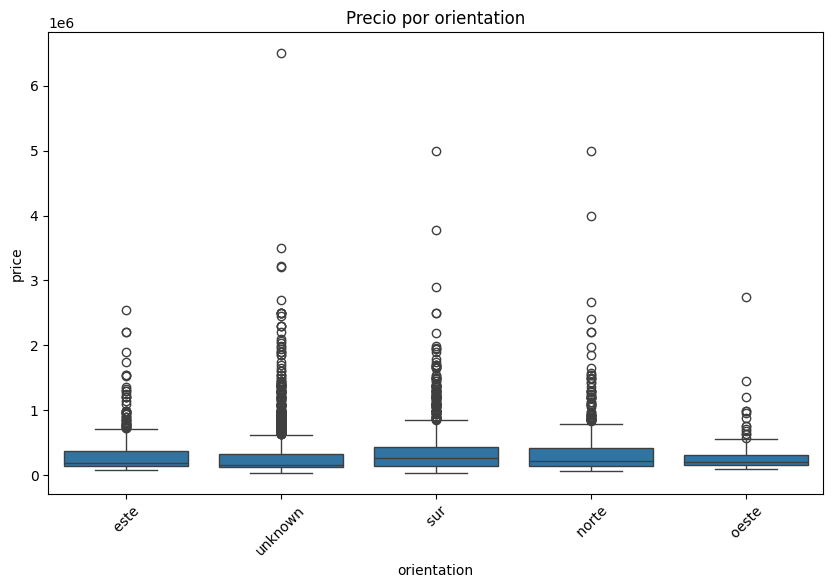

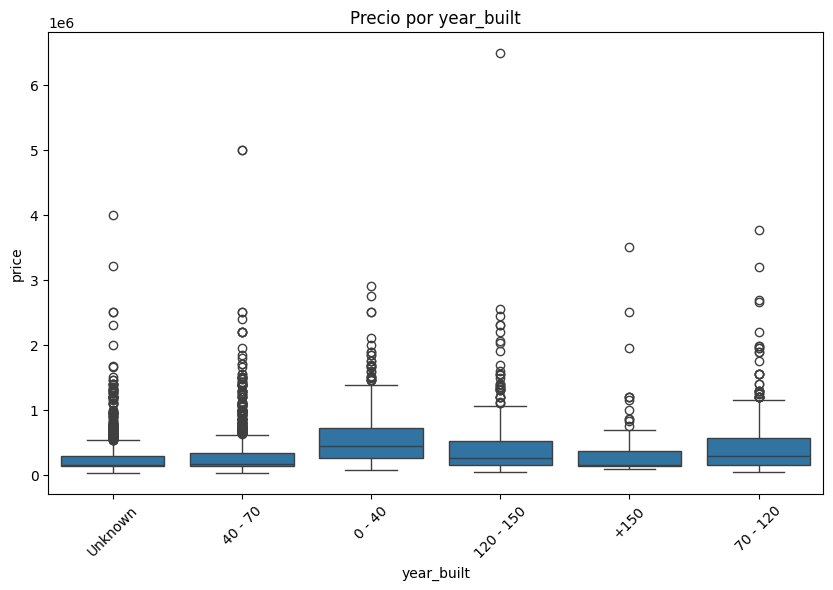

In [25]:
# Boxplots variable categóricas
cat_list = ['orientation', 'year_built']
for var in cat_list:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=var, y='price', data=sales_data)
    plt.title(f'Precio por {var}')
    plt.xticks(rotation=45) 
    plt.show()


En los boxplots se aprecia que los precios superiores provienen de media de pisos con orientación hacia el sur y de obra nueva(0-40)

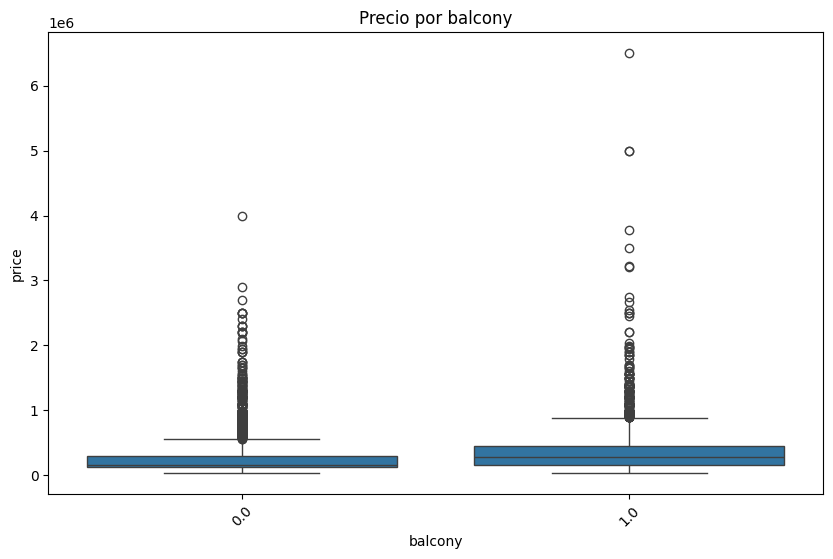

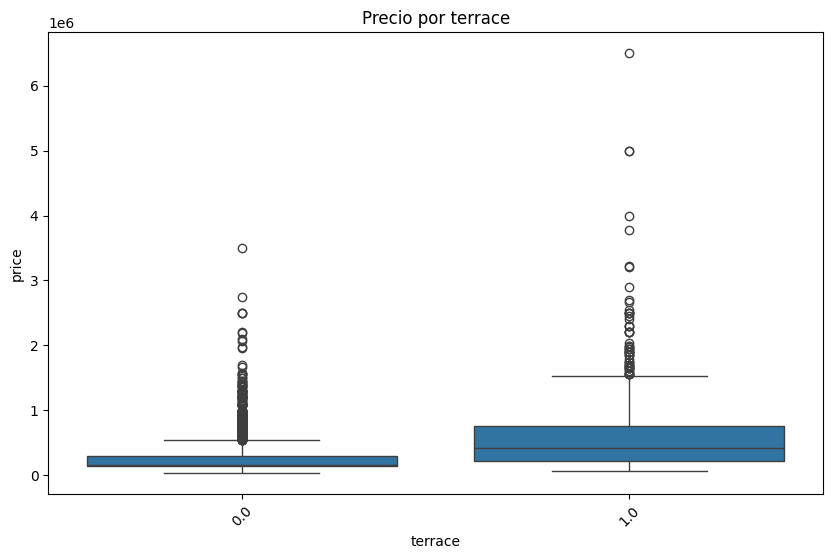

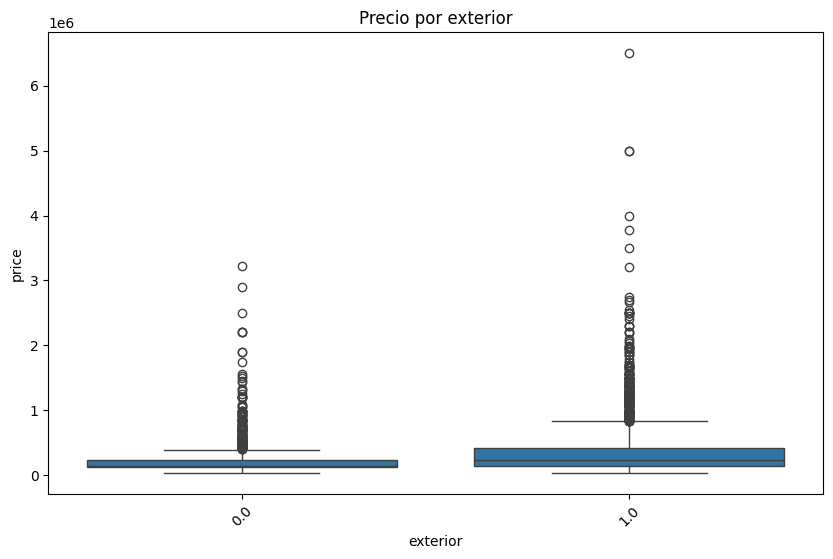

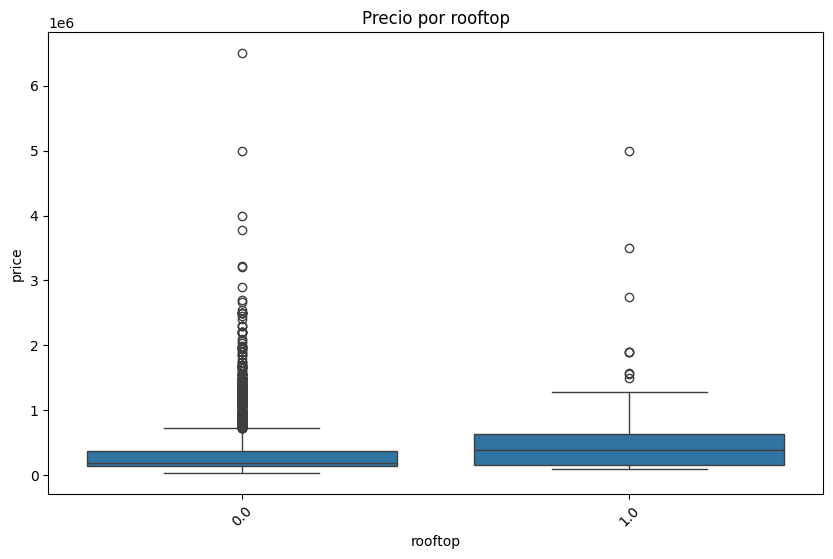

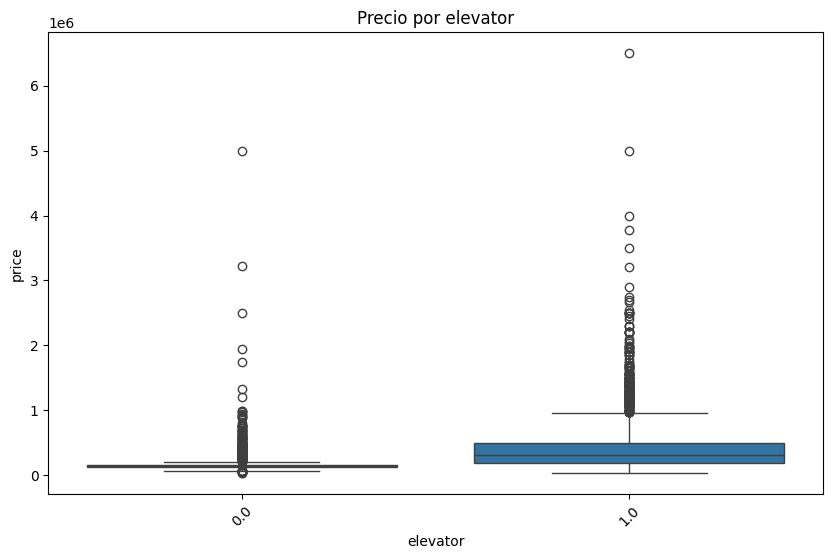

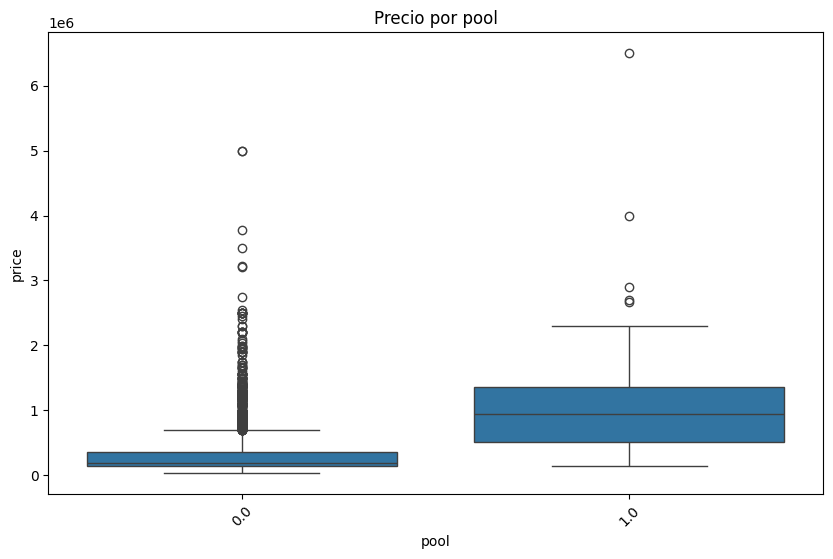

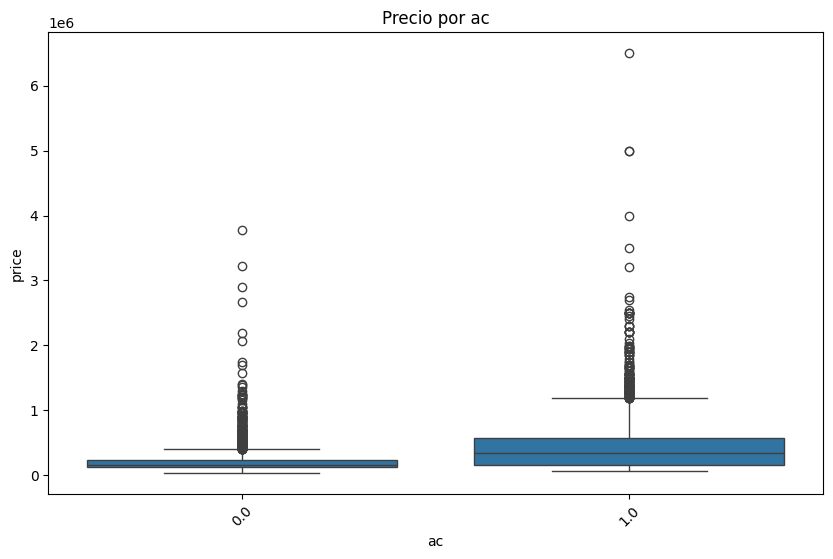

In [26]:
# Precio segmentado por variables binarias 
for var in bool_list:
    if len(sales_data[var].unique()) == 2:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=var, y='price', data=sales_data)
        plt.title(f'Precio por {var}')
        plt.xticks(rotation=45)
        plt.show()

Segun lo observado en los boxplots se puede interpretar que la posesion de cualquiera de los equipamientos anteriores(como piscina o terraza) aumentan el valor del immueble.

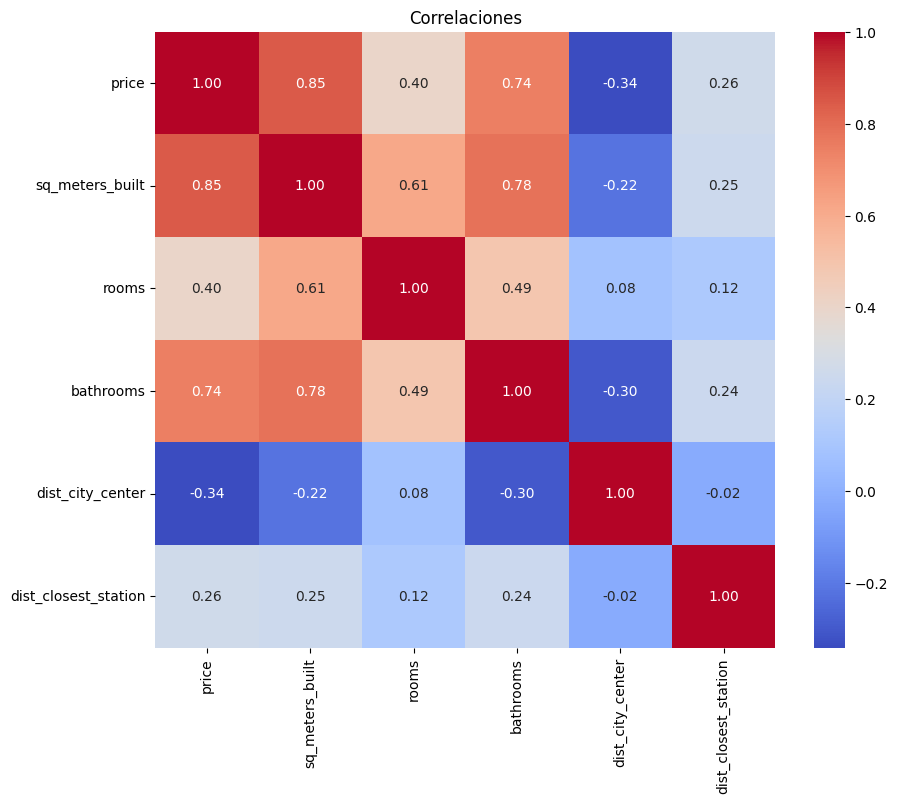

In [27]:
# Correlación

numeric_cols = sales_data.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols[(sales_data[numeric_cols].nunique() > 2)]

plt.figure(figsize=(10,8))
sns.heatmap(sales_data[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlaciones")
plt.show()

Se observa que las variables más correlacionadas con el precio son los metros cuadrados, el número de baños y el número de habitaciones, las cuales también están correlacionadas entre sí. Debido a esta multicolinealidad, los baños y las habitaciones no aportan explicabilidad adicional en su forma original. Para explorar nuevas relaciones, se transformarán estas variables en indicadores de densidad, calculando la cantidad de baños y habitaciones por cada 100 metros cuadrados.

In [28]:
# Habitaciones y baños según su densidad
sales_data['rooms_per_sqm'] = sales_data['rooms'] * 100 / sales_data['sq_meters_built']
sales_data['bathrooms_per_sqm'] = sales_data['bathrooms'] * 100 / sales_data['sq_meters_built']
sales_data = sales_data.drop(['rooms', 'bathrooms'], axis=1)
processed_df = sales_data
sales_data.head()

,price,sq_meters_built,balcony,terrace,exterior,orientation,rooftop,elevator,pool,ac,year_built,neighborhood,dist_city_center,dist_closest_station,rooms_per_sqm,bathrooms_per_sqm
0,150000,67,0.0,1.0,1.0,este,0.0,0.0,0.0,1.0,Unknown,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,0.121438,4.477612,1.492537
1,150000,52,0.0,0.0,1.0,unknown,0.0,0.0,0.0,1.0,Unknown,El Carmel,3.991000,0.277336,3.846154,1.923077
3,540000,100,0.0,0.0,1.0,sur,0.0,1.0,0.0,1.0,Unknown,Sant Gervasi - Galvany,2.257852,0.875652,3.000000,1.000000
4,650000,141,0.0,0.0,1.0,este,0.0,1.0,0.0,1.0,Unknown,Sarrià,4.283368,1.310073,2.127660,1.418440
5,128500,48,0.0,0.0,1.0,unknown,0.0,0.0,0.0,0.0,Unknown,Verdun,6.132079,0.439974,4.166667,2.083333


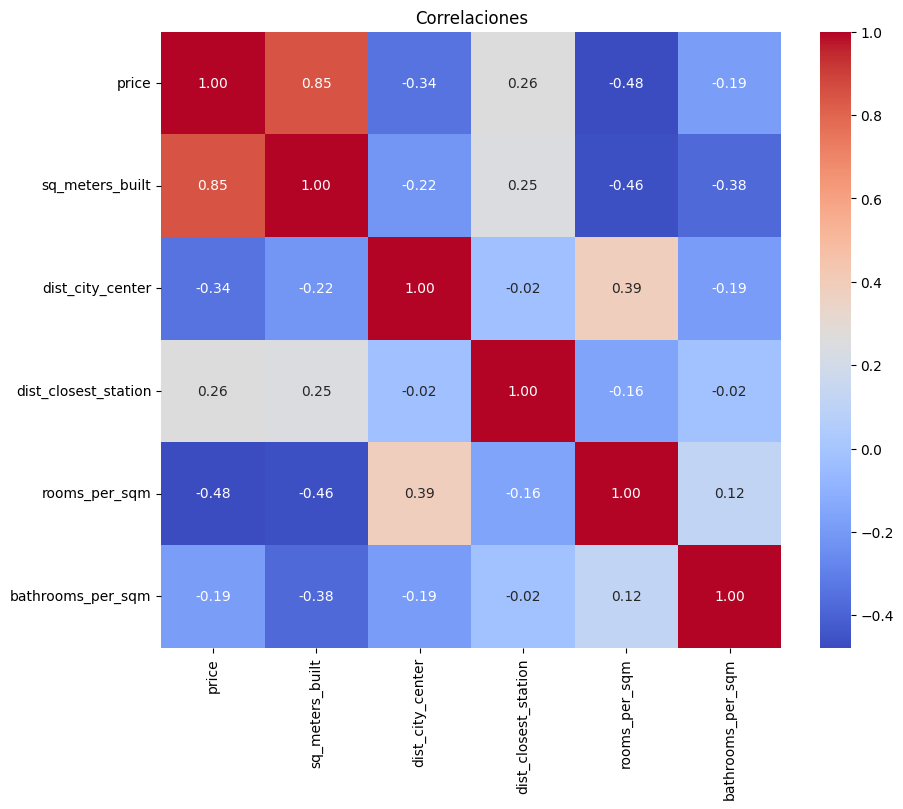

In [29]:
# Correlación
plt.figure(figsize=(10,8))

numeric_cols = sales_data.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols[(sales_data[numeric_cols].nunique() > 2)]

sns.heatmap(sales_data[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlaciones")
plt.show()

Posteriormente a los cambios, se aprecia como la relación entre los baños y las habitaciones con los metros cuadrados se ha reducido al igual que su impacto sobre lavriable objetivo precio. Aportando nueva información.

In [30]:
# Tabla con variables con correlacion > 0.3 respecto price
corr = sales_data[numeric_cols].corr()
correlation = corr["price"].abs()
selected_features = correlation[correlation > 0.3].index  

num_data = sales_data[selected_features]
print(num_data)

       price  sq_meters_built  dist_city_center  rooms_per_sqm
0     150000               67          7.990993       4.477612
1     150000               52          3.991000       3.846154
3     540000              100          2.257852       3.000000
4     650000              141          4.283368       2.127660
5     128500               48          6.132079       4.166667
...      ...              ...               ...            ...
5841  135000               31          2.618945       3.225806
5842  146000               63          4.750976       3.174603
5843   79000               34          7.346138       2.941176
5845  150000               79          7.019433       3.797468
5846  150000               85          7.213495       3.529412

[5111 rows x 4 columns]


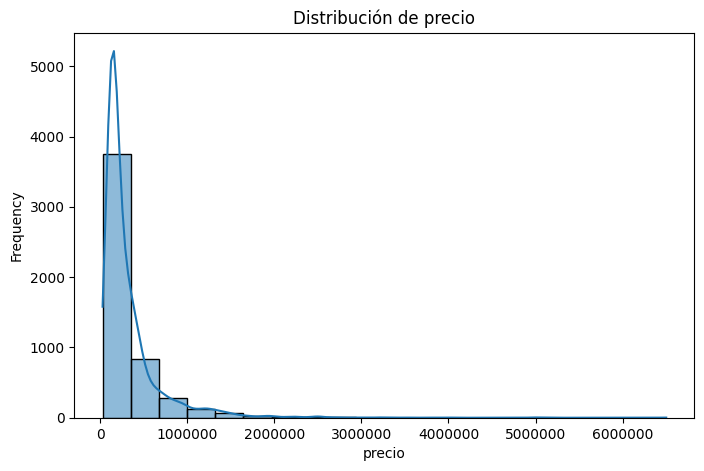

In [31]:
# distribución de precio
plt.figure(figsize=(8,5))
sns.histplot(num_data['price'], bins=20, kde=True)
plt.title("Distribución de precio")
plt.xlabel("precio")
plt.ticklabel_format(style='plain', axis='x')
plt.ylabel("Frequency")
plt.show()

Text(0.5, 0, 'Precio')

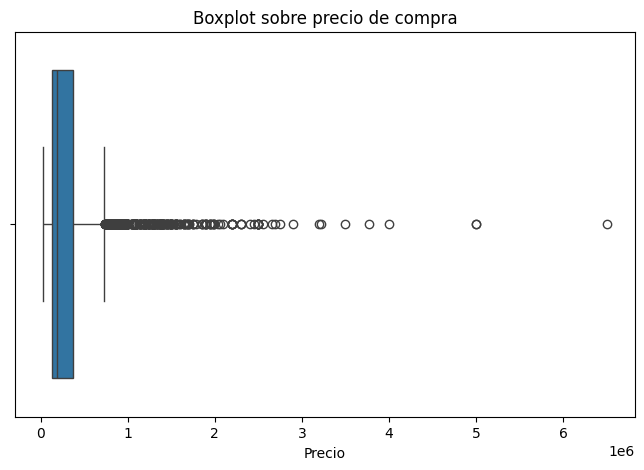

In [32]:
# boxplot del precio de compra
plt.figure(figsize=(8,5))
sns.boxplot(x=num_data['price'])
plt.title("Boxplot sobre precio de compra")
plt.xlabel("Precio")


In [33]:
# Descripción del precio de compra según sus persentiles
num_data['price'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

count    5.111000e+03
mean     3.250181e+05
std      3.650784e+05
min      2.800000e+04
10%      1.105000e+05
25%      1.360000e+05
50%      1.870000e+05
75%      3.750000e+05
90%      6.900000e+05
max      6.500000e+06
Name: price, dtype: float64

En el histograma y el boxplot se observa una clara asimetría a la derecha: la mayoría de los precios se concentran en valores bajos, mientras que existen valores extremos elevados que actúan como outliers. Al analizar los percentiles, se confirma esta distribución: entre el percentil 75 (375.000 €) y el 90 (690.000 €), el precio prácticamente se duplica, lo que refuerza la presencia de una cola larga hacia valores altos. Para evitar que los outliers impidan captar las relaciones correctamente se opta por eliminar los resultados por encima del percentil 75.

In [34]:
# filtrar percentil 75
num_data = num_data[(num_data['price'] <= 375000)]

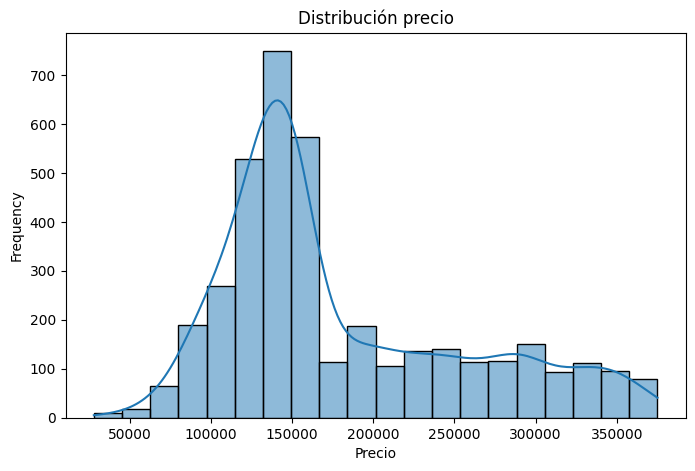

In [35]:
# Visualización de la distribución de precio
plt.figure(figsize=(8,5))
sns.histplot(num_data['price'], bins=20, kde=True)
plt.title("Distribución precio")
plt.xlabel("Precio")
plt.ylabel("Frequency")
plt.show()

Despues de probar varias posibilidades de rangos de precio, se opta por reducir el rango de 50000 a 200000 dado que obtenia un alto error en los precios altos. Perjudicando el rendimiento del modelo.

In [36]:
# rango 50000-200000
num_data = num_data[(num_data['price'] >= 50000) & (num_data['price'] <= 200000)]

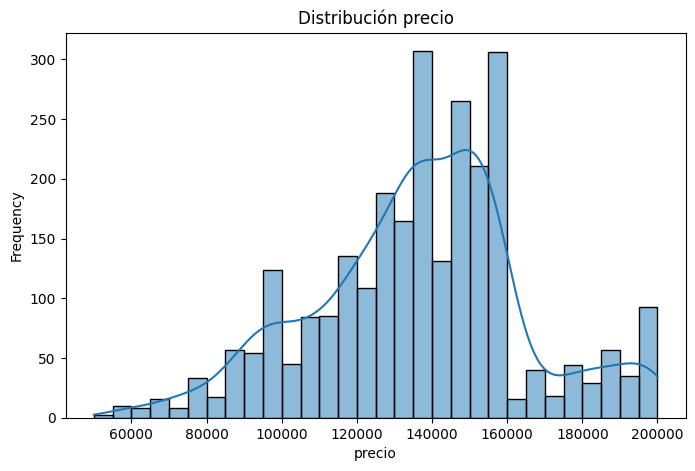

In [37]:
# Visualización de la distribución de precio
plt.figure(figsize=(8,5))
sns.histplot(num_data['price'], bins=30, kde=True)
plt.title("Distribución precio")
plt.xlabel("precio")
plt.ticklabel_format(style='plain', axis='x')
plt.ylabel("Frequency")
plt.show()

Text(0.5, 0, 'Precio')

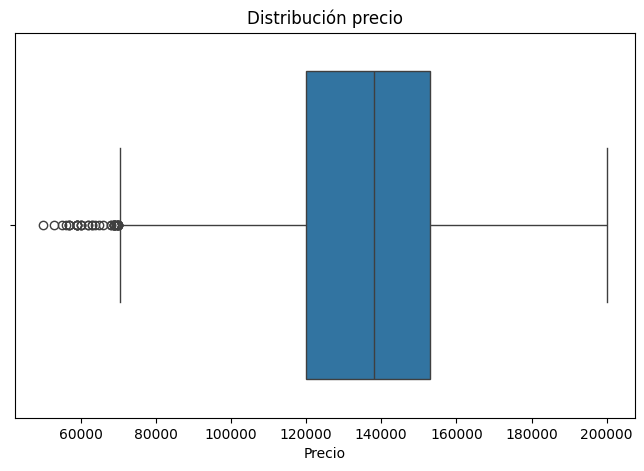

In [38]:
plt.figure(figsize=(8,5))
sns.boxplot(x=num_data['price'])
plt.title("Distribución precio")
plt.xlabel("Precio")

Tras acotar el análisis a propiedades con precios entre 50.000 € y 200.000 €, se aprecia que la mayoría de los inmuebles se sitúan en el tramo comprendido entre 120.000 € y 150.000 €.

In [39]:
num_data['price'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

count      2692.000000
mean     136344.021545
std       28151.494088
min       50000.000000
10%       97000.000000
25%      119900.000000
50%      138000.000000
75%      153000.000000
90%      170000.000000
max      200000.000000
Name: price, dtype: float64

## Bagging

In [40]:
X = num_data.drop(['price'], axis = 1)
y = num_data[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [41]:
# we enumerate the values to try
parameters = [{"max_depth":[2, 3, 5], "min_samples_split":[2,5]}, ]
# instantiate the classifier
decision_tree_model = DecisionTreeClassifier()

# Grid search function
grid_bag = GridSearchCV(cv = 10, estimator=decision_tree_model, param_grid=parameters, scoring="neg_mean_squared_error")
grid_bag.fit(X_train, y_train)

grid_bag.best_params_

c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


{'max_depth': 2, 'min_samples_split': 2}

In [42]:
parameters = [{"n_estimators":[50, 100, 200]}]
bagging_model = BaggingClassifier(decision_tree_model)

# Grid search function
grid_bag_depth = GridSearchCV(cv = 10
                              , estimator=bagging_model
                              , param_grid=parameters
                              , scoring="neg_mean_squared_error")

grid_bag_depth.fit(X_train, y_train)
grid_bag_depth.best_estimator_

c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=200)

In [43]:
# Modelo con hiperpametros seleccionados anteriormente
bag = BaggingClassifier(DecisionTreeClassifier(max_depth = grid_bag.best_params_['max_depth']
                                               , min_samples_split = grid_bag.best_params_['min_samples_split'])
                                               , n_estimators = grid_bag_depth.best_params_['n_estimators'])

model = cross_validate(bag, X_train, y_train, cv = 10, scoring = "neg_mean_squared_error")

c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected

In [44]:
# Resultados folds
for i, score in enumerate(model["test_score"]):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

Accuracy for the fold no. 0 on the test set: -657218958.3333334
Accuracy for the fold no. 1 on the test set: -686303224.0787038
Accuracy for the fold no. 2 on the test set: -728549097.0185186
Accuracy for the fold no. 3 on the test set: -739157034.8837209
Accuracy for the fold no. 4 on the test set: -710524332.6744186
Accuracy for the fold no. 5 on the test set: -656172663.255814
Accuracy for the fold no. 6 on the test set: -708866890.6976744
Accuracy for the fold no. 7 on the test set: -845580571.2604651
Accuracy for the fold no. 8 on the test set: -686981616.744186
Accuracy for the fold no. 9 on the test set: -790868290.6976744


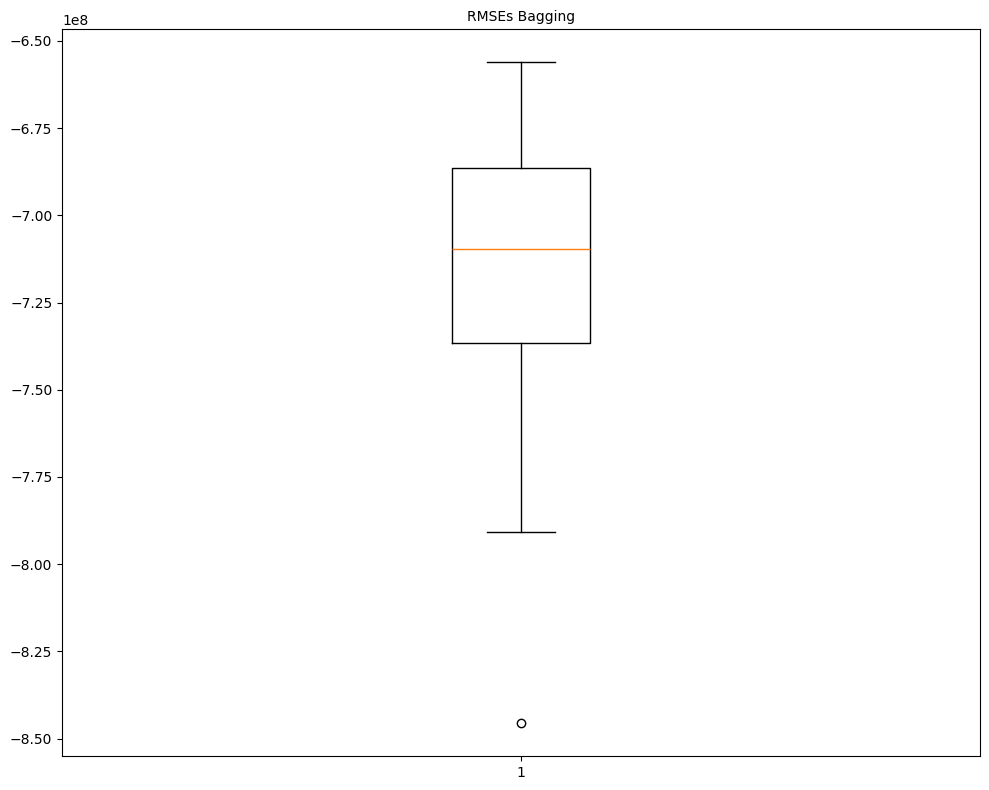

In [45]:
fig1, ax1 = plt.subplots(figsize=(10, 8))  
ax1.set_title('RMSEs Bagging', fontsize=10)
ax1.boxplot(model["test_score"])
plt.tight_layout()
plt.show()

In [46]:
bag = BaggingClassifier(DecisionTreeClassifier(max_depth = grid_bag.best_params_['max_depth']
                                               , min_samples_split = grid_bag.best_params_['min_samples_split'])
                        , n_estimators = grid_bag_depth.best_params_['n_estimators'])
bag.fit(X_train, y_train)

c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                  n_estimators=200)

In [47]:
# Entrenamiento
y_pred_train = bag.predict(X_train)
rmse_train = metrics.mean_squared_error(y_train, y_pred_train)
print("RMSE on training set:", rmse_train)

RMSE on training set: 720298414.957269


In [48]:
# Test
y_pred_test = bag.predict(X_test)
rmse_test = metrics.mean_squared_error(y_test, y_pred_test)
print("RMSE on test set:", rmse_test)

RMSE on test set: 753408044.0649351


In [49]:
#  Comparaciones valores predecidos vs reales
df = pd.DataFrame({'Actual': y_test['price'].values, 'Predicted': y_pred_test})
df['Delta'] = (df['Predicted'] - df['Actual'])
df['Perc'] = (df['Predicted'] - df['Actual']) / df['Actual']
df.head()

,Actual,Predicted,Delta,Perc
0,142000,150000,8000,0.056338
1,135000,150000,15000,0.111111
2,120000,150000,30000,0.250000
3,139000,135000,-4000,-0.028777
4,150000,150000,0,0.000000


Text(0.5, 1.0, 'Delta vs Reales')

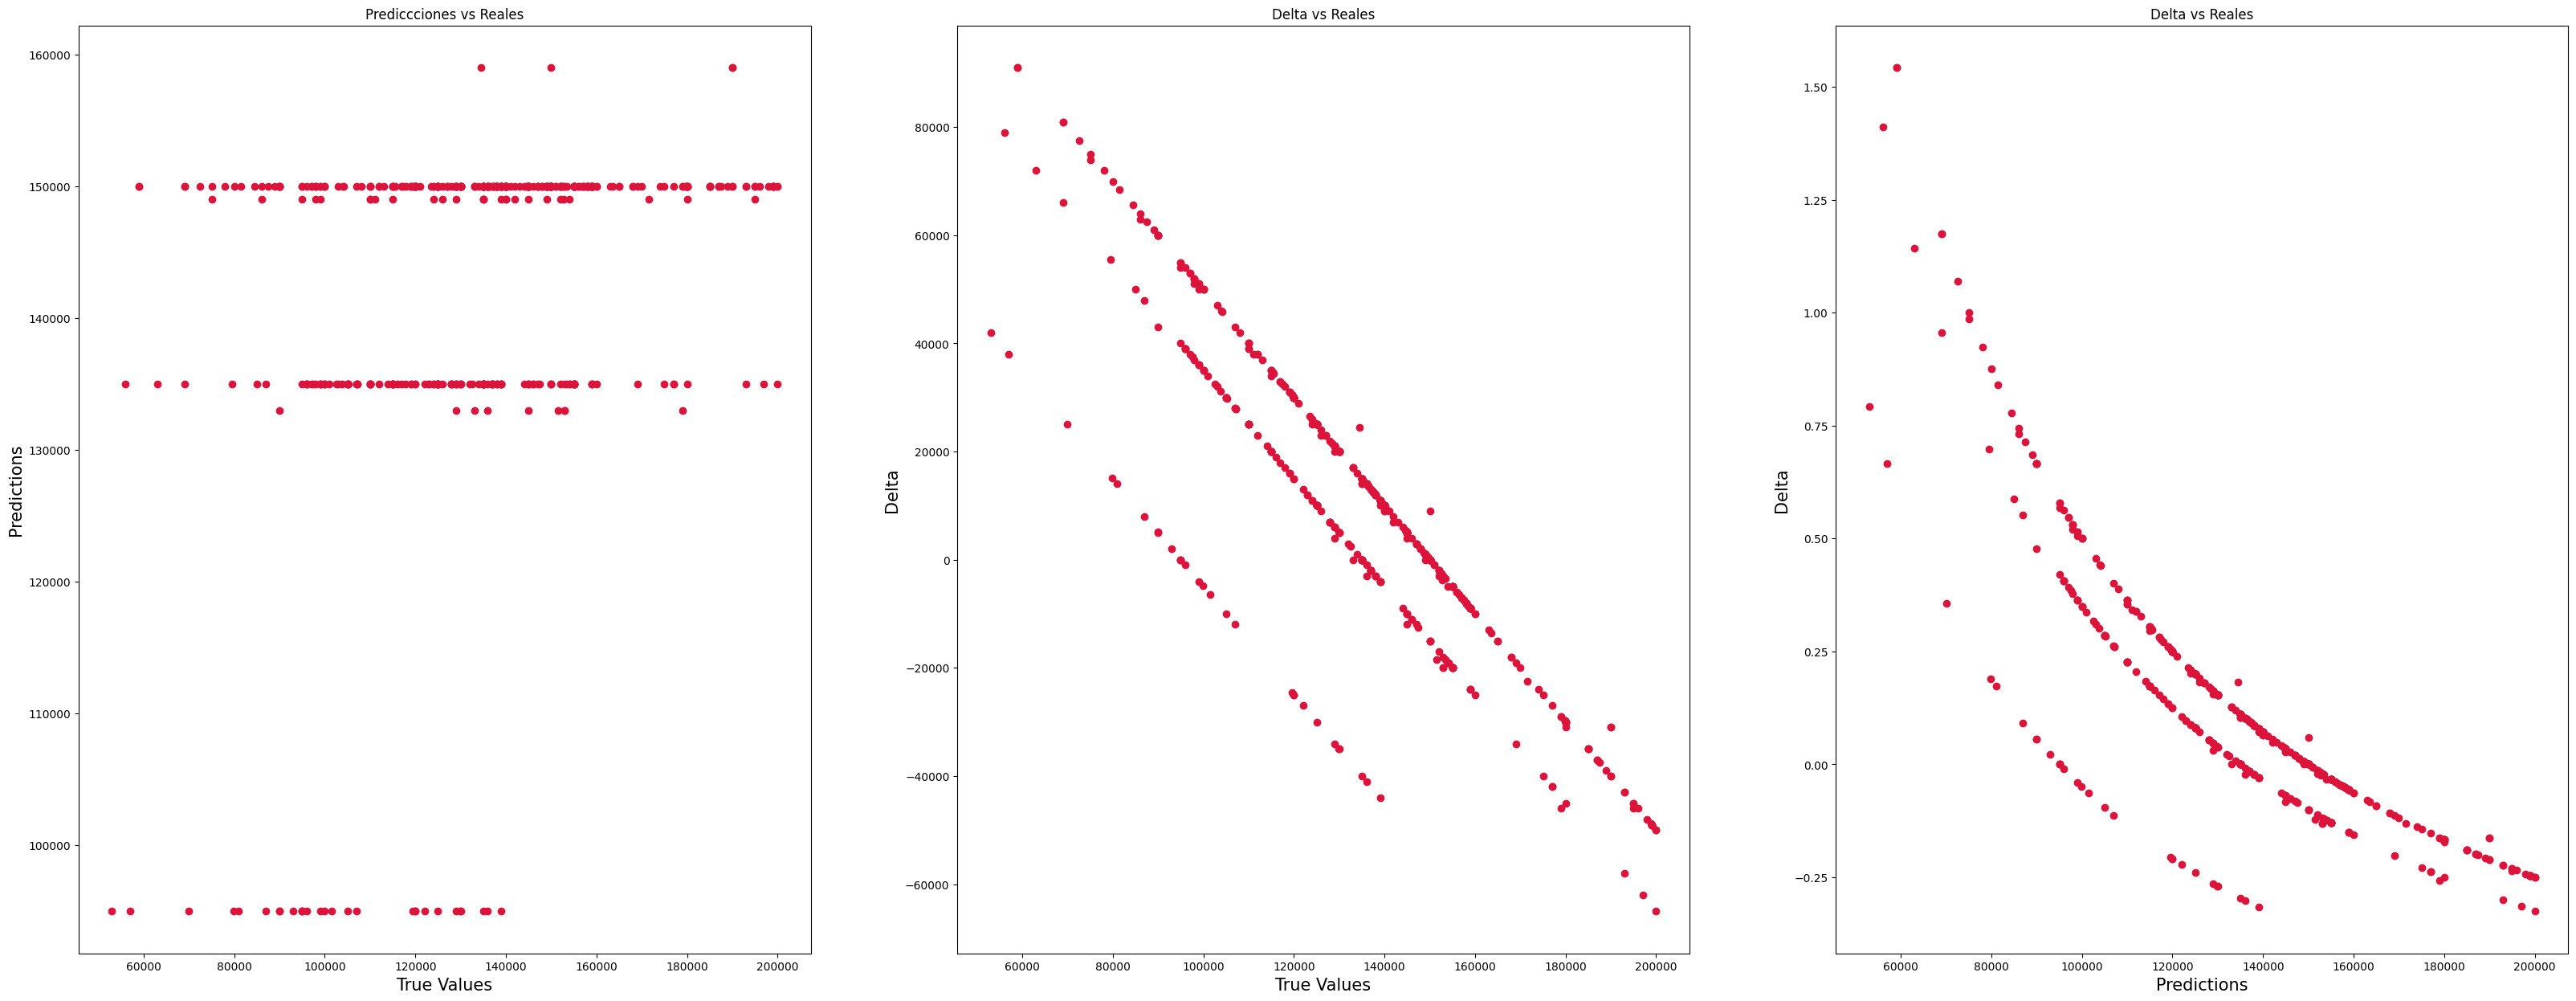

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(40, 15))

axs[0].scatter(df['Actual'], df['Predicted'], c='crimson')
axs[0].set_xlabel('True Values', fontsize=15)
axs[0].set_ylabel('Predictions', fontsize=15)
axs[0].set_title('Prediccciones vs Reales')

axs[1].scatter(df['Actual'], df['Delta'], c='crimson')
axs[1].set_xlabel('True Values', fontsize=15)
axs[1].set_ylabel('Delta', fontsize=15)
axs[1].set_title('Delta vs Reales')

axs[2].scatter(df['Actual'], df['Perc'], c='crimson')
axs[2].set_xlabel('Predictions', fontsize=15)
axs[2].set_ylabel('Delta', fontsize=15)
axs[2].set_title('Delta vs Reales')


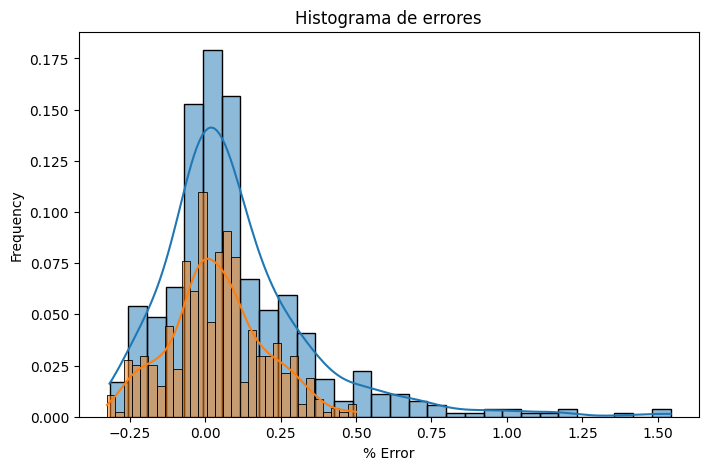

In [51]:
# Distribución precio predicho vs precio real
plt.figure(figsize=(8,5))
sns.histplot(df[df['Actual'] < 200000]['Perc'], bins=30, kde=True, stat="probability")
sns.histplot(df[df['Actual'] >= 100000]['Perc'], bins=30, kde=True, stat="probability")
plt.title("Histograma de errores")
plt.xlabel("% Error")
plt.ylabel("Frequency")
plt.show()

Ambas distribuciones se centran cerca del 0 % de error, lo que indica que el modelo tiene un desempeño razonable. Sin embargo, se observa que los errores en las viviendas más caras (azul) tienden a ser más dispersos y presentan una cola más larga hacia la derecha, lo que sugiere que el modelo tiende a infraestimar más a menudo los precios altos. Por otro lado, los errores en las viviendas más baratas (naranja) están más concentrados y controlados, con menos presencia de valores extremos.


In [52]:
# Entrenamiento
y_pred_train = bag.predict(X_train)
rmse_bagging_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_bagging_train = r2_score(y_train, y_pred_train)

# Test
y_pred_test = bag.predict(X_test)
rmse_bagging_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_bagging_test = r2_score(y_test, y_pred_test)

print("Entrenamiento:")
print("RMSE en el conjunto de entrenamiento:", rmse_bagging_train)
print("R² en el conjunto de entrenamiento:", r2_bagging_train)

print("\nTest:")
print("RMSE en el conjunto de test:", rmse_bagging_test)
print("R² en el conjunto de test:", r2_bagging_test)

Entrenamiento:
RMSE en el conjunto de entrenamiento: 26838.375788360758
R² en el conjunto de entrenamiento: 0.0976375018558936

Test:
RMSE en el conjunto de test: 27448.27943724224
R² en el conjunto de test: 0.017263318839067843


Se aprecia como los resultados de RMSE entre entrenamiento y test son bastante parecidos, el test empeora ligeramente ostrando un posible pequeño sobreajuste. En general esta bien ajustado y generaliza bastante bien. Por otro lado el r cuadrado se reduce drasticamente de 0.10 en train a 0.01 en test.

# Random Forest

In [53]:
sales = pd.read_csv('processed_sale_Barcelona.csv', delimiter = ',')
forest_data= transform_dataset(sales)
forest_data

,price,sq_meters_built,balcony,terrace,exterior,orientation,rooftop,elevator,pool,ac,year_built,neighborhood,dist_city_center,dist_closest_station,rooms_per_sqm,bathrooms_per_sqm
0,150000,67,0.0,1.0,1.0,este,0.0,0.0,0.0,1.0,Unknown,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,0.121438,4.411765,1.470588
1,150000,52,0.0,0.0,1.0,unknown,0.0,0.0,0.0,1.0,Unknown,El Carmel,3.991000,0.277336,3.773585,1.886792
5,128500,48,0.0,0.0,1.0,unknown,0.0,0.0,0.0,0.0,Unknown,Verdun,6.132079,0.439974,4.081633,2.040816
7,128000,74,0.0,0.0,0.0,unknown,0.0,0.0,0.0,0.0,Unknown,Horta Guinardó,4.071503,0.313419,4.000000,1.333333
8,117000,62,0.0,0.0,0.0,unknown,0.0,0.0,0.0,0.0,Unknown,Horta Guinardó,4.208601,0.308498,4.761905,1.587302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5841,135000,31,0.0,0.0,1.0,norte,0.0,1.0,0.0,0.0,70 - 120,Sant Gervasi - Galvany,2.618945,0.864460,3.125000,3.125000
5842,146000,63,0.0,0.0,0.0,unknown,0.0,1.0,0.0,1.0,40 - 70,Horta Guinardó,4.750976,0.341163,3.125000,1.562500
5843,79000,34,0.0,1.0,0.0,unknown,0.0,0.0,0.0,0.0,Unknown,Sant Andreu,7.346138,0.280344,2.857143,2.857143
5845,150000,79,0.0,0.0,1.0,unknown,0.0,1.0,0.0,0.0,Unknown,Baró de Viver,7.019433,0.440968,3.750000,1.250000


In [54]:
target = ['price']
num_features = ['sq_meters_built', 'bathrooms_per_sqm', 'rooms_per_sqm','floor', 'dist_city_center', 'dist_closest_station']
cat_features = ['neighborhood', 'year_built', 'orientation']
binary_features = ['balcony', 'terrace', 'exterior', 'rooftop', 'elevator', 'pool', 'ac']
non_num_features = binary_features + cat_features


In [55]:
for feature_name in non_num_features:
    regression_formula = f'price ~ {feature_name}'
    fitted_model = ols(regression_formula, data=forest_data).fit()
    anova_output = sm.stats.anova_lm(fitted_model, typ=2)
    print(f"\nANOVA para '{feature_name}':\n", anova_output)


ANOVA para 'balcony':
                 sum_sq      df         F        PR(>F)
balcony   3.172876e+10     1.0  57.45144  4.856586e-14
Residual  1.374602e+12  2489.0       NaN           NaN

ANOVA para 'terrace':
                 sum_sq      df        F    PR(>F)
terrace   1.051137e+09     1.0  1.86175  0.172546
Residual  1.405280e+12  2489.0      NaN       NaN

ANOVA para 'exterior':
                 sum_sq      df          F        PR(>F)
exterior  3.086154e+10     1.0  55.845935  1.079000e-13
Residual  1.375469e+12  2489.0        NaN           NaN

ANOVA para 'rooftop':
                 sum_sq      df         F    PR(>F)
rooftop   7.458201e+04     1.0  0.000132  0.990834
Residual  1.406331e+12  2489.0       NaN       NaN

ANOVA para 'elevator':
                 sum_sq      df           F        PR(>F)
elevator  9.532659e+10     1.0  180.981769  7.069110e-40
Residual  1.311004e+12  2489.0         NaN           NaN

ANOVA para 'pool':
                 sum_sq      df         F    PR(>F)

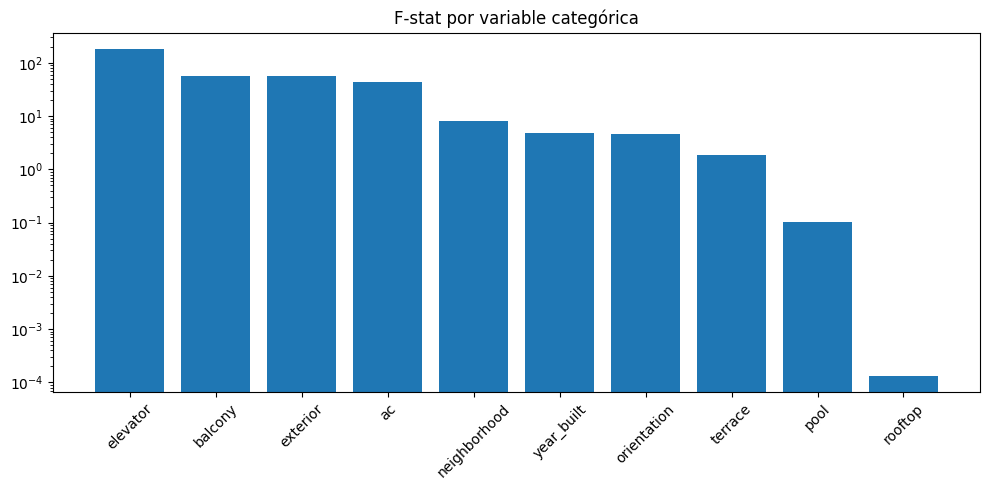

In [56]:
# Lista para almacenar los valores F de cada variable categórica
f_scores = []

# Evaluación de cada variable categórica de forma independiente
for feature in non_num_features:
    formula = f'price ~ {feature}'
    lm_model = ols(formula, data=forest_data).fit()
    anova_result = sm.stats.anova_lm(lm_model, typ=2)
    f_scores.append(anova_result.loc[feature, 'F'])

# Crear un DataFrame con los resultados
anova_summary = pd.DataFrame({
    'variable': non_num_features,
    'f_value': f_scores
})


anova_summary = anova_summary.sort_values('f_value', ascending=False)
plt.figure(figsize=(10, 5))
plt.bar(anova_summary['variable'], anova_summary['f_value'])
plt.yscale('log')
plt.xticks(rotation=45)
plt.title("F-stat por variable categórica")
plt.tight_layout()
plt.show()

A partir del análisis ANOVA, se observa que las variables pool, rooftop y terrace no tienen un efecto significativo sobre el precio, dado que sus p-valores superan el umbral de 0.05. Esto sugiere que no aportan evidencia estadística suficiente para considerarlas influyentes en el modelo. Por el contrario, el resto de atributos evaluados sí presentan una relación relevante con el precio del inmueble. Entre ellos, destacan especialmente elevator, balcony, exterior y ac, ya que sus valores F son notablemente más altos, indicando que explican en mayor medida la variabilidad del precio.

In [57]:
# Eliminar las variables no significativas
forest_data = forest_data.drop(columns=['pool', 'rooftop', 'terrace'], errors='ignore')

In [58]:
neighborhood = forest_data[['neighborhood', 'price', 'sq_meters_built']].groupby('neighborhood', as_index=False).agg(
    # Number of instances per category
    category_count=('price', "count"),
    # Mean price
    mean_price=('price', "mean"),
    # Mean price
    mean_sq_meters_built=('sq_meters_built', "mean"),
    # Median price
    median_price=('price', "median"),
    # Median price
    median_sq_meters_built=('sq_meters_built', "median"))

neighborhood['mean_price_per_sq_meters_built'] = neighborhood['mean_price'] / neighborhood['mean_sq_meters_built']
neighborhood['median_price_per_sq_meters_built'] = neighborhood['median_price'] / neighborhood['median_sq_meters_built']
neighborhood.head(60)

,neighborhood,category_count,mean_price,mean_sq_meters_built,median_price,median_sq_meters_built,mean_price_per_sq_meters_built,median_price_per_sq_meters_built
0,Baró de Viver,4,144725.000000,75.750000,150000.0,79.0,1910.561056,1898.734177
1,Can Baró,14,121600.000000,53.142857,117500.0,45.5,2288.172043,2582.417582
2,Can Peguera - El Turó de la Peira,72,120120.833333,60.722222,126000.0,60.0,1978.202196,2100.000000
3,Canyelles,2,139000.000000,80.000000,139000.0,80.0,1737.500000,1737.500000
4,Ciutat Meridiana - Torre Baró - Vallbona,114,112236.842105,65.035088,110000.0,65.0,1725.789048,1692.307692
5,Ciutat Vella,104,138095.769231,43.211538,140000.0,43.0,3195.807744,3255.813953
6,Diagonal Mar i el Front Marítim del Poblenou,1,163600.000000,65.000000,163600.0,65.0,2516.923077,2516.923077
7,Eixample,4,128500.000000,39.500000,127500.0,41.0,3253.164557,3109.756098
8,El Baix Guinardó,6,147783.333333,61.666667,149500.0,60.0,2396.486486,2491.666667
9,El Besòs,102,134326.960784,61.235294,141325.0,61.0,2193.619917,2316.803279


In [59]:
def neighborhood_conditions(x):
    if x < 0:
        return "Unknown"
    elif ((x >= 0) & (x < 11.5)):
        return "0-11.5"
    elif ((x >= 11.5) & (x < 15)):
        return "11.5-15"
    elif ((x >= 18)):
        return "+18"
    else:
        return "Unknown"

func = np.vectorize(neighborhood_conditions)
neighborhood['neighborhood_rent_index'] = func(neighborhood['median_price_per_sq_meters_built'])
neighborhood.head()

,neighborhood,category_count,mean_price,mean_sq_meters_built,median_price,median_sq_meters_built,mean_price_per_sq_meters_built,median_price_per_sq_meters_built,neighborhood_rent_index
0,Baró de Viver,4,144725.000000,75.750000,150000.0,79.0,1910.561056,1898.734177,+18
1,Can Baró,14,121600.000000,53.142857,117500.0,45.5,2288.172043,2582.417582,+18
2,Can Peguera - El Turó de la Peira,72,120120.833333,60.722222,126000.0,60.0,1978.202196,2100.000000,+18
3,Canyelles,2,139000.000000,80.000000,139000.0,80.0,1737.500000,1737.500000,+18
4,Ciutat Meridiana - Torre Baró - Vallbona,114,112236.842105,65.035088,110000.0,65.0,1725.789048,1692.307692,+18


In [60]:
neighborhood_mapping = neighborhood[['neighborhood', 'neighborhood_rent_index']]
forest_data = pd.merge(forest_data, neighborhood_mapping, on='neighborhood', how='left')
cat_features = cat_features.append('neighborhood_rent_index')
forest_data.head()

,price,sq_meters_built,balcony,exterior,orientation,elevator,ac,year_built,neighborhood,dist_city_center,dist_closest_station,rooms_per_sqm,bathrooms_per_sqm,neighborhood_rent_index
0,150000,67,0.0,1.0,este,0.0,1.0,Unknown,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,0.121438,4.411765,1.470588,+18
1,150000,52,0.0,1.0,unknown,0.0,1.0,Unknown,El Carmel,3.991000,0.277336,3.773585,1.886792,+18
2,128500,48,0.0,1.0,unknown,0.0,0.0,Unknown,Verdun,6.132079,0.439974,4.081633,2.040816,+18
3,128000,74,0.0,0.0,unknown,0.0,0.0,Unknown,Horta Guinardó,4.071503,0.313419,4.000000,1.333333,+18
4,117000,62,0.0,0.0,unknown,0.0,0.0,Unknown,Horta Guinardó,4.208601,0.308498,4.761905,1.587302,+18


In [61]:
def one_hot_encoder(df, cat_feature):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(enc.fit_transform(forest_data[[cat_feature]]).toarray())
    enc_df.columns = enc.categories_[0]
    enc_df = enc_df.add_prefix(cat_feature + '_')
    return df.join(enc_df)

In [62]:
num_forest = one_hot_encoder(forest_data, 'neighborhood_rent_index')
num_forest = one_hot_encoder(forest_data, 'year_built')
num_forest = one_hot_encoder(forest_data, 'orientation')
num_forest.drop(['neighborhood', 'orientation', 'neighborhood_rent_index', 'year_built'], axis=1, inplace=True)
num_forest.columns

Index(['price', 'sq_meters_built', 'balcony', 'exterior', 'elevator', 'ac',
       'dist_city_center', 'dist_closest_station', 'rooms_per_sqm',
       'bathrooms_per_sqm', 'orientation_ este', 'orientation_ norte',
       'orientation_ oeste', 'orientation_ sur', 'orientation_unknown'],
      dtype='object')

In [63]:
X = num_forest.drop(['price'], axis = 1)
y = num_forest[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# Busqueda de parametros
parametros_grid = {
    "n_estimators": [60, 80, 100],
    "max_depth": [5]
}

modelo_rf = RandomForestClassifier()

busqueda_grid = GridSearchCV(
    estimator=modelo_rf,
    param_grid=parametros_grid,
    cv=10,
    scoring="neg_mean_squared_error"
)

busqueda_grid.fit(X_train, y_train)

mejores_parametros = busqueda_grid.best_params_
print("Mejores parámetros encontrados:", mejores_parametros)

c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

Mejores parámetros encontrados: {'max_depth': 5, 'n_estimators': 80}


c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

Error cuadrático medio en el fold 0: -500717113.0000
Error cuadrático medio en el fold 1: -666445461.1250
Error cuadrático medio en el fold 2: -582716481.5377
Error cuadrático medio en el fold 3: -629663304.0201
Error cuadrático medio en el fold 4: -547665094.9749
Error cuadrático medio en el fold 5: -722709880.0251
Error cuadrático medio en el fold 6: -599053436.8090
Error cuadrático medio en el fold 7: -484862927.6432
Error cuadrático medio en el fold 8: -507569466.8342
Error cuadrático medio en el fold 9: -466549120.6030


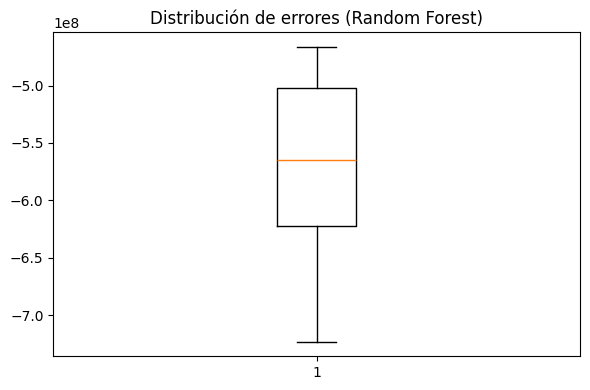

In [65]:
# Ejecucion modelo
rf = RandomForestClassifier(
    n_estimators=busqueda_grid.best_params_['n_estimators'],
    max_depth=busqueda_grid.best_params_['max_depth']
)

# Se aplican 10 particiones
resultados_cv = cross_validate(
    estimator=rf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring="neg_mean_squared_error"
)

# Mostramos los resultados de cada fold
for idx, error in enumerate(resultados_cv["test_score"]):
    print(f"Error cuadrático medio en el fold {idx}: {error:.4f}")


plt.figure(figsize=(6, 4))
plt.boxplot(resultados_cv["test_score"])
plt.title("Distribución de errores (Random Forest)")
plt.tight_layout()
plt.show()

In [66]:
# Entrenamiento del modelo
rf.fit(X_train, y_train)

# Predicción en train
y_pred_train = rf.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
print("Entrenamiento:")
print("RMSE en el conjunto de entrenamiento:", rmse_train)
print("R² en el conjunto de entrenamiento:", r2_train)

# Predicción en test
y_pred_test = rf.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
print("\nTest:")
print("RMSE en el conjunto de test:", rmse_test)
print("R² en el conjunto de test:", r2_test)

c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Entrenamiento:
RMSE en el conjunto de entrenamiento: 22849.985070770566
R² en el conjunto de entrenamiento: 0.07947989031768754

Test:
RMSE en el conjunto de test: 24049.52412783985
R² en el conjunto de test: -0.04536585524099368


In [67]:
# Predicho vs real
df = pd.DataFrame({'Actual': y_test['price'].values, 'Predicted': y_pred_test})
df['Delta'] = (df['Predicted'] - df['Actual'])
df['Perc'] = (df['Predicted'] - df['Actual']) / df['Actual']
df.head()

,Actual,Predicted,Delta,Perc
0,154500,150000,-4500,-0.029126
1,115000,145000,30000,0.260870
2,145000,150000,5000,0.034483
3,125889,125000,-889,-0.007062
4,125000,150000,25000,0.200000


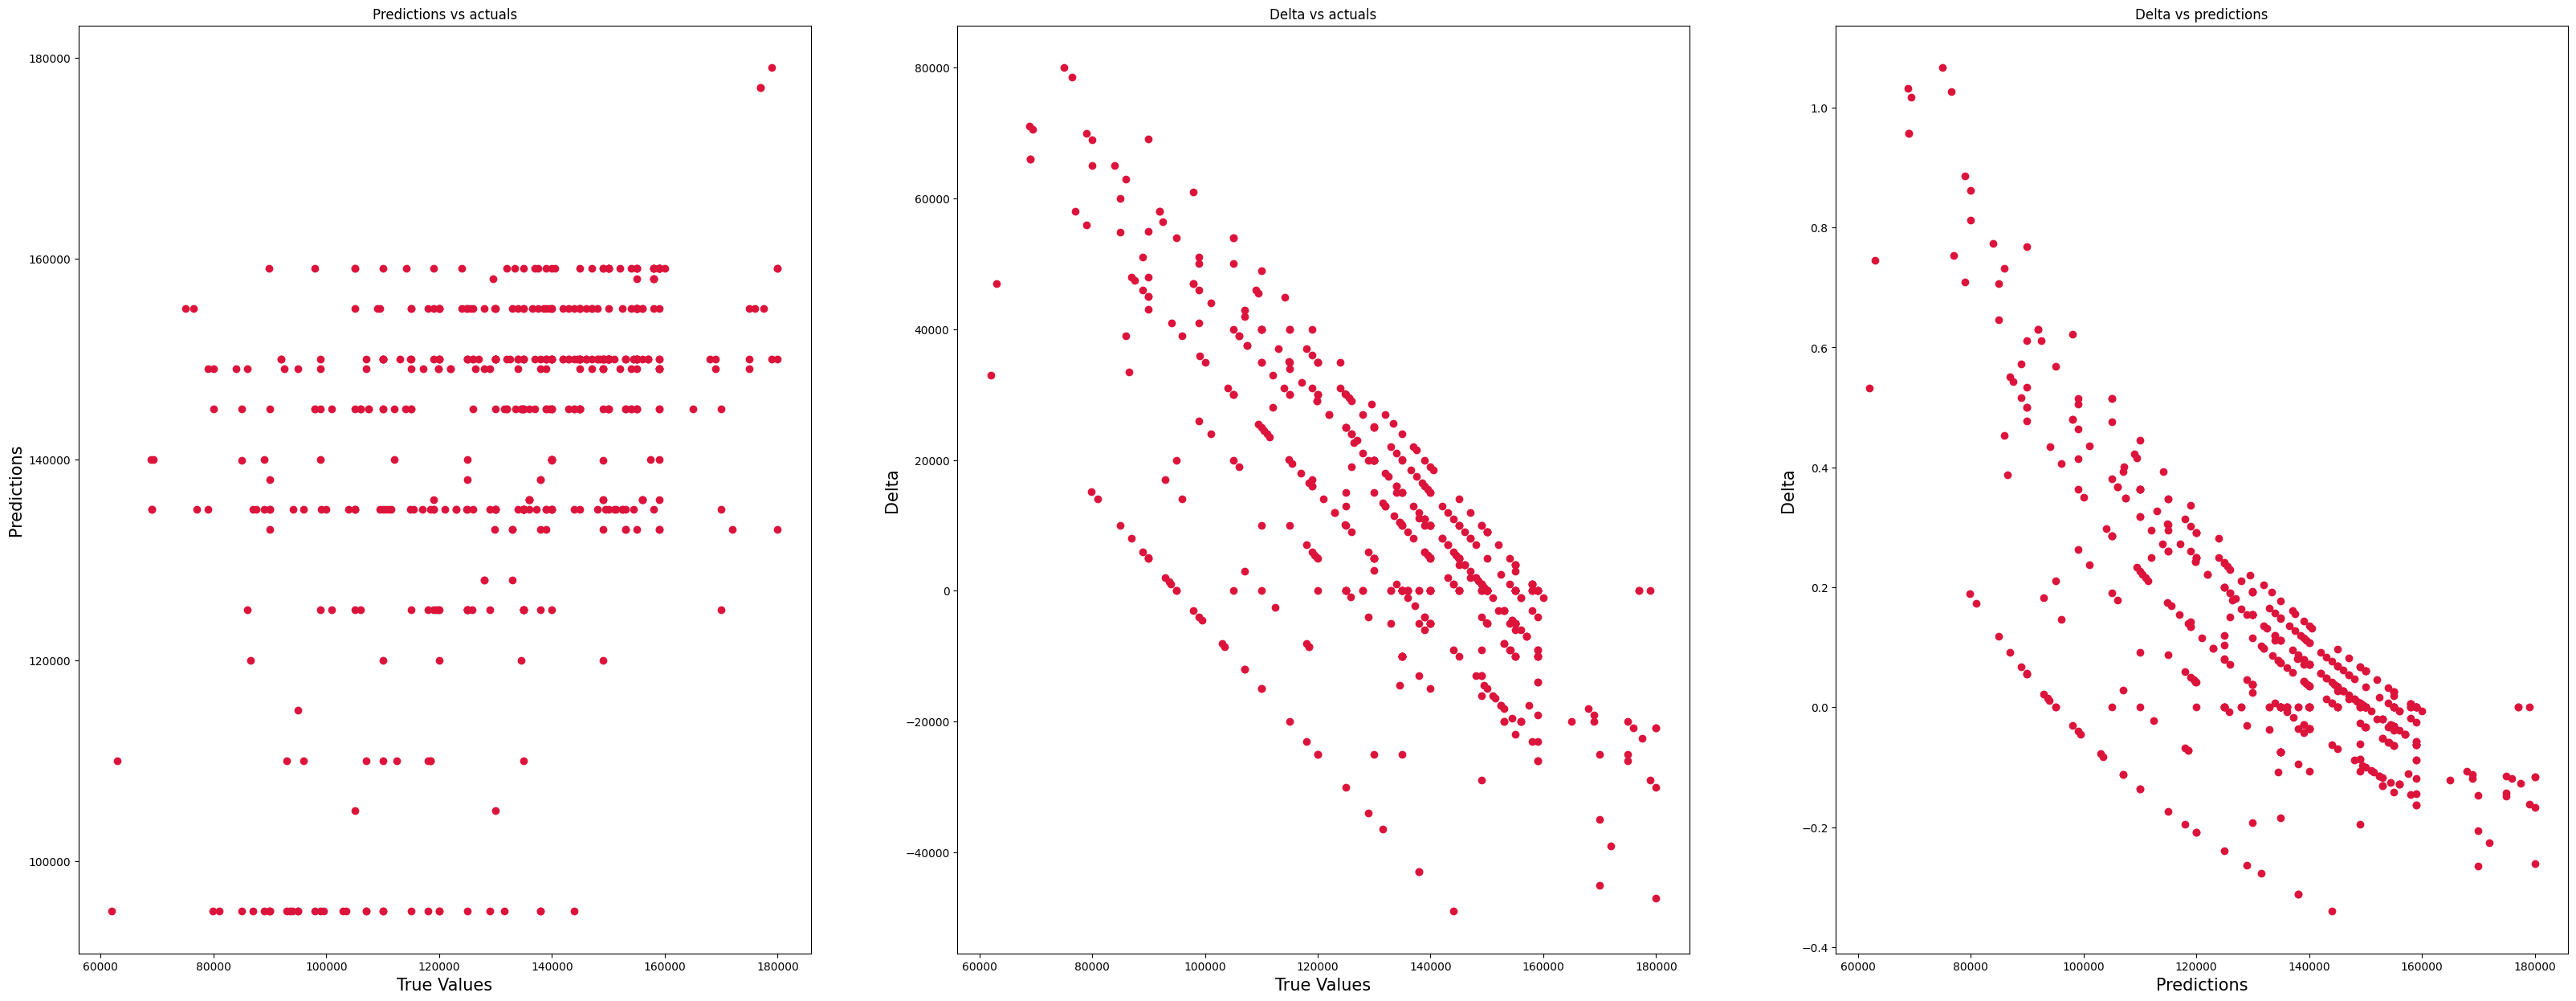

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(40, 15))

axs[0].scatter(df['Actual'], df['Predicted'], c='crimson')
axs[0].set_xlabel('True Values', fontsize=15)
axs[0].set_ylabel('Predictions', fontsize=15)
axs[0].set_title('Predictions vs actuals')

axs[1].scatter(df['Actual'], df['Delta'], c='crimson')
axs[1].set_xlabel('True Values', fontsize=15)
axs[1].set_ylabel('Delta', fontsize=15)
axs[1].set_title('Delta vs actuals')

axs[2].scatter(df['Actual'], df['Perc'], c='crimson')
axs[2].set_xlabel('Predictions', fontsize=15)
axs[2].set_ylabel('Delta', fontsize=15)
axs[2].set_title('Delta vs predictions')
plt.show()

Dado que el RMSE en el conjunto de entrenamiento es de aproximadamente 22.967 € y en el de test ronda los 23.850 €, se observa una diferencia mínima entre ambos conjuntos. Esto sugiere que el modelo está bien calibrado y consigue generalizar de forma adecuada. Aunque los errores siguen siendo relativamente altos en comparación con el rango de precios, se ha logrado una mejora respecto al modelo anterior basado en bagging, y no se aprecian signos evidentes de sobreajuste ni infraajuste. La diferencia en R cuadrado es bastante mayor. En este caso en train es 0.10 y test 0.2.

# XGBOOST

In [69]:
sales = pd.read_csv('processed_sale_Barcelona.csv', delimiter = ',')
xgboost_data = transform_dataset(sales)
xgboost_data

,price,sq_meters_built,balcony,terrace,exterior,orientation,rooftop,elevator,pool,ac,year_built,neighborhood,dist_city_center,dist_closest_station,rooms_per_sqm,bathrooms_per_sqm
0,150000,67,0.0,1.0,1.0,este,0.0,0.0,0.0,1.0,Unknown,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,0.121438,4.411765,1.470588
1,150000,52,0.0,0.0,1.0,unknown,0.0,0.0,0.0,1.0,Unknown,El Carmel,3.991000,0.277336,3.773585,1.886792
5,128500,48,0.0,0.0,1.0,unknown,0.0,0.0,0.0,0.0,Unknown,Verdun,6.132079,0.439974,4.081633,2.040816
7,128000,74,0.0,0.0,0.0,unknown,0.0,0.0,0.0,0.0,Unknown,Horta Guinardó,4.071503,0.313419,4.000000,1.333333
8,117000,62,0.0,0.0,0.0,unknown,0.0,0.0,0.0,0.0,Unknown,Horta Guinardó,4.208601,0.308498,4.761905,1.587302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5841,135000,31,0.0,0.0,1.0,norte,0.0,1.0,0.0,0.0,70 - 120,Sant Gervasi - Galvany,2.618945,0.864460,3.125000,3.125000
5842,146000,63,0.0,0.0,0.0,unknown,0.0,1.0,0.0,1.0,40 - 70,Horta Guinardó,4.750976,0.341163,3.125000,1.562500
5843,79000,34,0.0,1.0,0.0,unknown,0.0,0.0,0.0,0.0,Unknown,Sant Andreu,7.346138,0.280344,2.857143,2.857143
5845,150000,79,0.0,0.0,1.0,unknown,0.0,1.0,0.0,0.0,Unknown,Baró de Viver,7.019433,0.440968,3.750000,1.250000


In [70]:
target = ['price']
numeric_features = ['sq_meters_built', 'rooms_per_sqm', 'bathrooms_per_sqm', 'balcony'
                    , 'exterior',  'elevator', 'ac'
                    , 'dist_city_center', 'dist_closest_station']

xgboost_data = xgboost_data[numeric_features + target]

In [71]:
# Separar X e y
X = xgboost_data.drop(target, axis=1)
y = xgboost_data[target]

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definimos el espacio de búsqueda de hiperparámetros
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 1],
    "colsample_bytree": [0.7, 1]
}

# Instanciamos el modelo base
xgb_model = XGBRegressor(random_state=42)

# Grid Search con validación cruzada
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Ejecutamos la búsqueda
grid_search.fit(X_train, y_train)

# Resultados del grid search
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Modelo final entrenado
best_model = grid_search.best_estimator_

# Predicciones
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Métricas en entrenamiento
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

# Métricas en test
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

# Resultados
print("\nEvaluación del mejor modelo:")
print(f"R² en entrenamiento: {r2_train:.4f}")
print(f"R² en test        : {r2_test:.4f}")
print(f"RMSE en entrenamiento: {rmse_train:.2f}")
print(f"RMSE en test        : {rmse_test:.2f}")

Fitting 10 folds for each of 72 candidates, totalling 720 fits


c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\xg

Mejores hiperparámetros encontrados:
{'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}

Evaluación del mejor modelo:
R² en entrenamiento: 0.7887
R² en test        : 0.4429
RMSE en entrenamiento: 10947.60
RMSE en test        : 17556.07


# SHAP

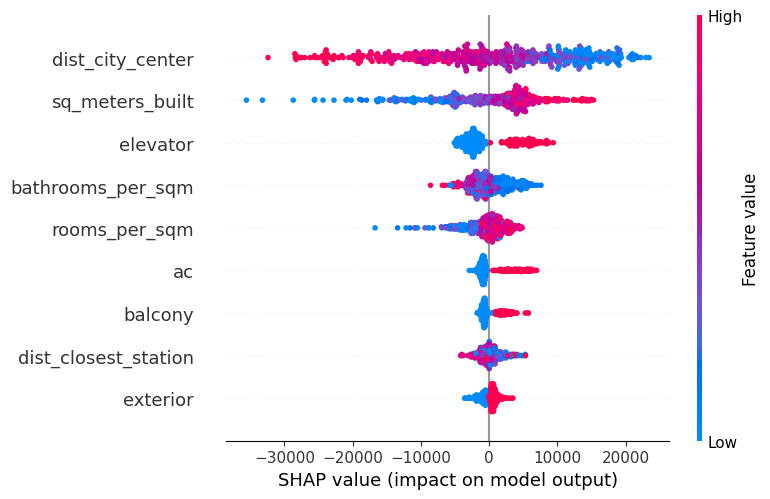

In [ ]:
explainer = shap.Explainer(best_model, X_train)

# Calcular SHAP values sobre el conjunto de test
shap_values = explainer(X_test)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test)

Mediante el análisis de valores SHAP, se puede determinar la relevancia de cada variable en la predicción del precio de los inmuebles.

Tal como refleja la figura, los atributos que más contribuyen al aumento del precio son:

- La superficie construida (sq_meters_built), con un impacto positivo especialmente en los valores altos.

- La cercanía al centro de la ciudad (dist_city_center), cuya menor distancia se asocia con precios más elevados.

- La presencia de ascensor (elevator) y aire acondicionado (ac), elementos que incrementan notablemente el valor de la propiedad.

En contraste, las variables que más influyen en una disminución del precio son:

- Una mayor proporción de baños o habitaciones por metro cuadrado, lo cual puede indicar una distribución menos eficiente.

- La distancia a la estación más próxima (dist_closest_station).

- La ausencia de elementos como balcón o cualidades exteriores, que también restan valor a la vivienda.

En conjunto, el modelo confiere una importancia destacada a la variable de ubicación, especialmente la proximidad al centro urbano, lo que reafirma su papel central en la determinación del precio de mercado. Asimismo, las características estructurales y de confort del inmueble son factores clave en la valoración final.




RESULTADOS MODELOS

Xgboost:
- R² train: 0.7887
- R² test: 0.4429

- RMSE train: 10947.60
- RMSE test        : 17556.07


Random Forest:
- RMSE train 22469.41
- RMSE test 23178.58 

- R² train 0.1098  
- R² Test 0.0289 


Bagging:
- RMSE train 26678.50  
- RMSE test 27457.96

- R²  train 0.1083 
- R² test 0.01656  

Observando los resultados finales, se concluye que el modelo XGBoost, entrenado exclusivamente con variables numéricas, ha sido el que ha obtenido el mejor rendimiento, con un RMSE de 17,556.07 y un R² de 0.4429. Si bien estas métricas reflejan un desempeño aceptable y una capacidad razonable para explicar la variabilidad del precio, el nivel de precisión alcanzado aún podría considerarse insuficiente en contextos donde se requiera una estimación muy precisa del valor de los inmuebles. Por tanto, aunque el modelo muestra potencial, sería recomendable explorar mejoras adicionales, como la incorporación de variables categóricas relevantes o ajustes de ingeniería de características.

# DATASET ALQUILER

In [73]:
rent = pd.read_csv('processed_renting_Barcelona.csv', delimiter = ',')
rent

,id,price,currency,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,...,neighborhood,dist_city_center,furniture,garage,property_type,garden,closest_station,dist_closest_station,created_at,last_seen
0,536625,850,€/mes,41.401708,2.154077,52.0,55,2,1,NaN,...,Gràcia,2.026455,3.0,NaN,piso,NaN,Fontana,0.094111,9/1/2021 15:58,10/4/2021 6:01
1,545910,725,€/mes,41.407221,2.135569,32.0,37,2,1,1.0,...,Sant Gervasi - La Bonanova,3.582409,NaN,NaN,piso,NaN,Vallcarca,0.902561,9/2/2021 15:24,9/8/2021 12:29
2,570697,950,€/mes,41.411508,2.164608,NaN,72,3,1,NaN,...,El Baix Guinardó,2.663025,3.0,NaN,piso,NaN,Alfons X,0.188177,8/28/2021 23:52,8/28/2021 23:52
3,591588,750,€/mes,41.402256,2.140764,NaN,45,1,1,1.0,...,Sant Gervasi - La Bonanova,2.910067,3.0,NaN,piso,NaN,Lesseps,0.892917,8/29/2021 11:25,9/8/2021 12:29
4,610243,990,€/mes,41.405327,2.146929,NaN,45,1,1,NaN,...,Sarrià-Sant Gervasi,2.727149,3.0,NaN,piso,NaN,Lesseps,0.293784,8/30/2021 13:48,8/30/2021 14:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8497,95892645,907,€/mes,41.379977,2.158180,45.0,49,0,1,NaN,...,Sant Antoni,1.317748,3.0,NaN,estudio,NaN,Urgell,0.285426,11/12/2021 15:05,11/12/2021 15:05
8498,95893664,950,€/mes,41.424420,2.171016,104.0,125,1,1,NaN,...,La Font d'En Fargues,4.063099,NaN,NaN,piso,NaN,Maragall,0.534462,11/12/2021 16:05,11/12/2021 16:05
8499,95893690,950,€/mes,41.385917,2.167686,45.0,48,2,1,NaN,...,El Raval,0.288753,NaN,NaN,piso,NaN,Catalunya,0.261938,11/12/2021 16:05,11/12/2021 16:05
8500,95895013,926,€/mes,41.379902,2.124309,48.0,51,2,1,1.0,...,La Maternitat i Sant Ramon,3.909033,NaN,1.0,piso,NaN,Badal,0.545561,11/12/2021 15:05,11/12/2021 15:05


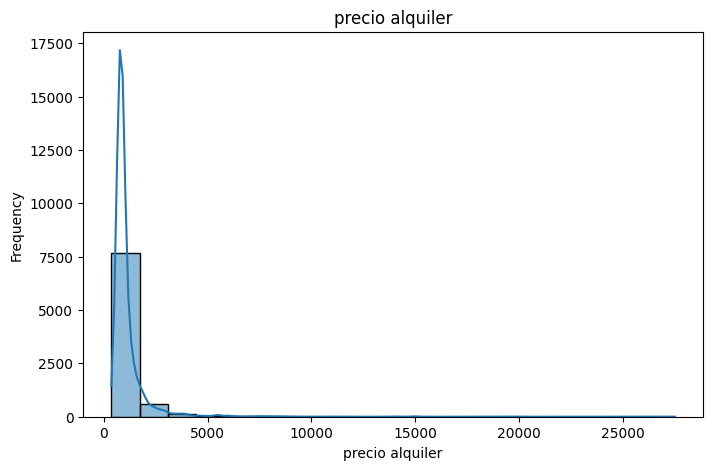

In [74]:
plt.figure(figsize=(8,5))
sns.histplot(rent['price'], bins=20, kde=True)
plt.title("precio alquiler")
plt.xlabel("precio alquiler")
plt.ylabel("Frequency")
plt.show()

Text(0.5, 0, 'Precio alquiler')

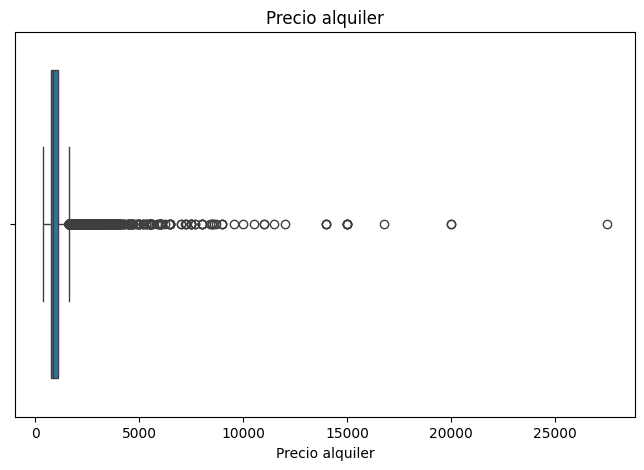

In [75]:
plt.figure(figsize=(8,5))
sns.boxplot(x=rent['price'])
plt.title("Precio alquiler")
plt.xlabel("Precio alquiler")

In [76]:
rent['price'].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9])

count     8502.000000
mean      1117.482828
std       1010.198242
min        365.000000
5%         650.000000
10%        695.000000
25%        768.250000
50%        850.000000
75%       1100.000000
90%       1700.000000
max      27500.000000
Name: price, dtype: float64

In [77]:
def transform_rent(dataset):
    # Variables a eliminar que no se necesitan
    delete_list = ['id', 'currency', 'latitude', 'longitude', 'floor', 'sq_meters', 'quality',
                   'city', 'furniture', 'garage', 'garden', 'closest_station', 'heating',
                   'created_at', 'last_seen', 'doorman']
    dataset = drop_list(dataset, delete_list)

    # Asegurar que las variables booleanas estén en formato 0/1 y sin NAs
    bool_list = ['balcony', 'exterior', 'elevator', 'ac']
    dataset = transform_bool(dataset, bool_list)

    # Transformaciones numéricas necesarias para crear los ratios
    num_list = ['sq_meters_built', 'rooms', 'bathrooms']
    dataset = transform_num(dataset, num_list)

    # Crear variables derivadas
    dataset = create_ratio_variables(dataset)

    return dataset

rent = transform_rent(rent)

In [78]:
target = ['price']
numeric_features = ['sq_meters_built', 'rooms_per_sqm', 'bathrooms_per_sqm', 'balcony'
                    , 'exterior',  'elevator', 'ac'
                    , 'dist_city_center', 'dist_closest_station']

rent = rent[numeric_features + target]

In [79]:
X = rent.drop(target, axis=1)
y = rent[target]

# División en training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

# Hiperparámetros utilizados previamente
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=1,
    colsample_bytree=1,
    random_state=37
)

# Entrenamiento
xgb_model.fit(X_train, y_train)

# Predicción y métricas en train
y_pred_train = xgb_model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Predicción y métricas en test
y_pred_test = xgb_model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Resultados
print("Evaluación del modelo XGBoost:")
print(f"R² en entrenamiento: {r2_train:.4f}")
print(f"R² en test: {r2_test:.4f}")
print(f"RMSE en entrenamiento: {rmse_train:.2f}")
print(f"RMSE en test: {rmse_test:.2f}")

Evaluación del modelo XGBoost:
R² en entrenamiento: 0.9429
R² en test: 0.8092
RMSE en entrenamiento: 245.08
RMSE en test: 413.14


Las predicciones obtenidas para el modelo de alquiler son altamente satisfactorias, con un R² en el conjunto de test de 0.8092 y un RMSE de 413.14, lo que indica una buena capacidad predictiva. No obstante, el R² en el conjunto de entrenamiento alcanza un valor de 0.9429, considerablemente superior al de test, lo que podría sugerir una ligera presencia de sobreajuste. A pesar de ello, la diferencia no es excesiva, por lo que el modelo sigue mostrando un rendimiento robusto y generalizable.

# BREAK EVEN

In [ ]:
# Rehaciendo dataset de precio de compra para aplicarle el modelo de alquiler

# Funciones para transformación de caracteristicas

# Función para eliminar variables que no aportan valor
def drop_list(dataset, delete_list):
    return dataset.drop(delete_list, axis=1)


# Transformar variables NA Booleanas en 0
def transform_bool(dataset, swap_list):
    for i in swap_list:
        dataset[i] = dataset[i].fillna(0)
    return dataset

# Transformar 'year_built' en categórica
def transform_year_built(year_built):
    if pd.isna(year_built) or year_built < 0:
        return "Unknown"
    elif year_built < 40:
        return "0 - 40"
    elif year_built < 70:
        return "40 - 70"
    elif year_built < 120:
        return "70 - 120"
    elif year_built < 150:
        return "120 - 150"
    else:
        return "+150"

# Transformar valores NA en 'unknown' en categóricas
def transform_na(dataset, swap_list):
    for i in swap_list:
        dataset[i] = dataset[i].fillna('unknown')
    return dataset


# Función para transformar valores NA en 0 para variables numéricas
def transform_num(dataset, num_list):
    for i in num_list:
        dataset[i] = dataset[i].fillna(0)
    return dataset

# Crear variables ratio
def create_ratio_variables(df):
    df['rooms_per_sqm'] = df['rooms'] * 100 / (df['sq_meters_built'] + 1)
    df['bathrooms_per_sqm'] = df['bathrooms'] * 100 / (df['sq_meters_built'] + 1)
    df.drop(['rooms', 'bathrooms'], axis=1, inplace=True)
    return df

# Función para filtrar por rango de precios y tipo de propiedad 'piso'
def filter_price(dataset, min_price, max_price):
    processed_data = dataset[(dataset['price'] >= min_price) &
                             (dataset['price'] <= max_price) &
                             (dataset['property_type'] == 'piso')]

    # Eliminar la columna 'property_type' ya que todas las propiedades son 'piso'
    processed_data = processed_data.drop(columns=['property_type'])

    return processed_data

# Función general
def transform_dataset(dataset):
    # Variables a eliminar
    delete_list = [ 'currency', 'latitude', 'longitude', 'floor', 'sq_meters', 'quality',
                   'city', 'furniture', 'garage', 'garden', 'closest_station', 'heating',
                   'created_at', 'last_seen', 'doorman']
    # 'id',

    #  Variables boleanas con valores NA a transformar
    bool_list = ['balcony', 'terrace', 'exterior', 'rooftop', 'elevator', 'pool', 'ac']

    # Variables cat con valores NA a transformar
    cat_list = ['orientation', 'neighborhood', 'property_type']

    # Variabeles númericas a transformar
    num_list = ['sq_meters_built', 'rooms', 'bathrooms']

    # Eliminar variables que no aportan información
    dataset = drop_list(dataset, delete_list)

    # Transformar variables booleanas NA en 0
    dataset = transform_bool(dataset, bool_list)

    # Transformar la columna 'year_built' en el número de años desde su construcción
    dataset['year_built'] = 2025 - dataset['year_built']

    # Función para transformar 'year_built' en categórica
    dataset['year_built'] = dataset['year_built'].apply(transform_year_built)

    # Transformar valores nulos como categória 'unknown'
    dataset = transform_na(dataset, cat_list)

    # Transformar valores nulos numéricos NA en 0
    dataset = transform_num(dataset, num_list)

    # Crear variables de ratio
    dataset = create_ratio_variables(dataset)

    return dataset

sales = pd.read_csv('processed_sale_Barcelona.csv', delimiter = ',')
xgboost_data = transform_dataset(sales)
xgboost_data

,id,price,sq_meters_built,balcony,terrace,exterior,orientation,rooftop,elevator,pool,ac,year_built,neighborhood,dist_city_center,property_type,dist_closest_station,rooms_per_sqm,bathrooms_per_sqm
0,320294,150000,67,0.0,1.0,1.0,este,0.0,0.0,0.0,1.0,Unknown,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,piso,0.121438,4.411765,1.470588
1,1786997,150000,52,0.0,0.0,1.0,unknown,0.0,0.0,0.0,1.0,Unknown,El Carmel,3.991000,piso,0.277336,3.773585,1.886792
2,1787143,395000,91,0.0,0.0,1.0,unknown,0.0,0.0,0.0,1.0,Unknown,El Poblenou,3.579261,duplex,0.383878,2.173913,2.173913
3,1976767,540000,100,0.0,0.0,1.0,sur,0.0,1.0,0.0,1.0,Unknown,Sant Gervasi - Galvany,2.257852,piso,0.875652,2.970297,0.990099
4,27972575,650000,141,0.0,0.0,1.0,este,0.0,1.0,0.0,1.0,Unknown,Sarrià,4.283368,piso,1.310073,2.112676,1.408451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5842,95887577,146000,63,0.0,0.0,0.0,unknown,0.0,1.0,0.0,1.0,40 - 70,Horta Guinardó,4.750976,piso,0.341163,3.125000,1.562500
5843,95889306,79000,34,0.0,1.0,0.0,unknown,0.0,0.0,0.0,0.0,Unknown,Sant Andreu,7.346138,piso,0.280344,2.857143,2.857143
5844,95892003,84900,30,0.0,0.0,0.0,unknown,0.0,0.0,0.0,1.0,Unknown,Ciutat Vella,0.971988,estudio,0.157078,0.000000,3.225806
5845,95893093,150000,79,0.0,0.0,1.0,unknown,0.0,1.0,0.0,0.0,Unknown,Baró de Viver,7.019433,piso,0.440968,3.750000,1.250000


In [102]:
target = ['price']
numeric_features = ['sq_meters_built', 'rooms_per_sqm', 'bathrooms_per_sqm', 'balcony'
                    , 'exterior',  'elevator', 'ac'
                    , 'dist_city_center', 'dist_closest_station']

xgboost_data = xgboost_data[numeric_features + target]
xgboost_data 

,sq_meters_built,rooms_per_sqm,bathrooms_per_sqm,balcony,exterior,elevator,ac,dist_city_center,dist_closest_station,price
0,67,4.411765,1.470588,0.0,1.0,0.0,1.0,7.990993,0.121438,150000
1,52,3.773585,1.886792,0.0,1.0,0.0,1.0,3.991000,0.277336,150000
2,91,2.173913,2.173913,0.0,1.0,0.0,1.0,3.579261,0.383878,395000
3,100,2.970297,0.990099,0.0,1.0,1.0,1.0,2.257852,0.875652,540000
4,141,2.112676,1.408451,0.0,1.0,1.0,1.0,4.283368,1.310073,650000
...,...,...,...,...,...,...,...,...,...,...
5842,63,3.125000,1.562500,0.0,0.0,1.0,1.0,4.750976,0.341163,146000
5843,34,2.857143,2.857143,0.0,0.0,0.0,0.0,7.346138,0.280344,79000
5844,30,0.000000,3.225806,0.0,0.0,0.0,1.0,0.971988,0.157078,84900
5845,79,3.750000,1.250000,0.0,1.0,1.0,0.0,7.019433,0.440968,150000


In [ ]:
# Guardamos el precio de venta en una variable separada
precios_venta = xgboost_data["price"].copy()

# Creamos una versión solo con las variables del modelo (sin 'price')
X_rent_input = xgboost_data.drop(columns=["price"])

# Predecimos el alquiler mensual
alquiler_estimado = xgb_model.predict(X_rent_input)

# Volvemos a añadir las columnas al DataFrame original
xgboost_data["alquiler_estimado"] = alquiler_estimado
xgboost_data["break_even_meses"] = precios_venta / alquiler_estimado

xgboost_data

C:\Users\Ivan\AppData\Local\Temp\ipykernel_25820\2537497899.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_data["alquiler_estimado"] = alquiler_estimado
C:\Users\Ivan\AppData\Local\Temp\ipykernel_25820\2537497899.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_data["break_even_meses"] = precios_venta / alquiler_estimado


,sq_meters_built,rooms_per_sqm,bathrooms_per_sqm,balcony,exterior,elevator,ac,dist_city_center,dist_closest_station,price,alquiler_estimado,break_even_meses
0,67,4.411765,1.470588,0.0,1.0,0.0,1.0,7.990993,0.121438,150000,740.288208,202.623787
1,52,3.773585,1.886792,0.0,1.0,0.0,1.0,3.991000,0.277336,150000,787.712891,190.424712
2,91,2.173913,2.173913,0.0,1.0,0.0,1.0,3.579261,0.383878,395000,1153.818726,342.341471
3,100,2.970297,0.990099,0.0,1.0,1.0,1.0,2.257852,0.875652,540000,2312.432373,233.520343
4,141,2.112676,1.408451,0.0,1.0,1.0,1.0,4.283368,1.310073,650000,3084.197510,210.751743
...,...,...,...,...,...,...,...,...,...,...,...,...
5842,63,3.125000,1.562500,0.0,0.0,1.0,1.0,4.750976,0.341163,146000,875.919312,166.682020
5843,34,2.857143,2.857143,0.0,0.0,0.0,0.0,7.346138,0.280344,79000,585.566956,134.911984
5844,30,0.000000,3.225806,0.0,0.0,0.0,1.0,0.971988,0.157078,84900,705.158386,120.398483
5845,79,3.750000,1.250000,0.0,1.0,1.0,0.0,7.019433,0.440968,150000,760.983643,197.113304


In [ ]:
# Cálculo usando metricas de metros cuadrados

xgboost_data["precio_m2"] = xgboost_data["price"] / xgboost_data["sq_meters_built"]
xgboost_data["alquiler_m2"] = xgboost_data["alquiler_estimado"] / xgboost_data["sq_meters_built"]

xgboost_data["break_even_m2"] = xgboost_data["precio_m2"] / xgboost_data["alquiler_m2"]

xgboost_data

C:\Users\Ivan\AppData\Local\Temp\ipykernel_25820\848364988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_data["precio_m2"] = xgboost_data["price"] / xgboost_data["sq_meters_built"]
C:\Users\Ivan\AppData\Local\Temp\ipykernel_25820\848364988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_data["alquiler_m2"] = xgboost_data["alquiler_estimado"] / xgboost_data["sq_meters_built"]
C:\Users\Ivan\AppData\Local\Temp\ipykernel_25820\848364988.py:4: SettingWithCopyWarning: 
A value is trying 

,sq_meters_built,rooms_per_sqm,bathrooms_per_sqm,balcony,exterior,elevator,ac,dist_city_center,dist_closest_station,price,alquiler_estimado,break_even_meses,precio_m2,alquiler_m2,break_even_m2
0,67,4.411765,1.470588,0.0,1.0,0.0,1.0,7.990993,0.121438,150000,740.288208,202.623787,2238.805970,11.049078,202.623787
1,52,3.773585,1.886792,0.0,1.0,0.0,1.0,3.991000,0.277336,150000,787.712891,190.424712,2884.615385,15.148325,190.424712
2,91,2.173913,2.173913,0.0,1.0,0.0,1.0,3.579261,0.383878,395000,1153.818726,342.341471,4340.659341,12.679327,342.341471
3,100,2.970297,0.990099,0.0,1.0,1.0,1.0,2.257852,0.875652,540000,2312.432373,233.520343,5400.000000,23.124324,233.520343
4,141,2.112676,1.408451,0.0,1.0,1.0,1.0,4.283368,1.310073,650000,3084.197510,210.751743,4609.929078,21.873741,210.751743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5842,63,3.125000,1.562500,0.0,0.0,1.0,1.0,4.750976,0.341163,146000,875.919312,166.682020,2317.460317,13.903481,166.682020
5843,34,2.857143,2.857143,0.0,0.0,0.0,0.0,7.346138,0.280344,79000,585.566956,134.911984,2323.529412,17.222558,134.911984
5844,30,0.000000,3.225806,0.0,0.0,0.0,1.0,0.971988,0.157078,84900,705.158386,120.398483,2830.000000,23.505280,120.398483
5845,79,3.750000,1.250000,0.0,1.0,1.0,0.0,7.019433,0.440968,150000,760.983643,197.113304,1898.734177,9.632704,197.113304


In [107]:
top_rentables = xgboost_data.sort_values("break_even_m2").head(10)
top_rentables

,sq_meters_built,rooms_per_sqm,bathrooms_per_sqm,balcony,exterior,elevator,ac,dist_city_center,dist_closest_station,price,alquiler_estimado,break_even_meses,precio_m2,alquiler_m2,break_even_m2
410,80,4.938272,2.469136,1.0,0.0,1.0,0.0,1.984758,0.427798,29000,1080.647095,26.835773,362.500000,13.508089,26.835773
1218,118,2.521008,1.680672,1.0,0.0,1.0,1.0,4.745571,0.394894,65000,2027.157837,32.064597,550.847458,17.179304,32.064597
303,182,2.185792,1.639344,0.0,1.0,0.0,0.0,4.543856,0.181409,200000,5369.695801,37.246058,1098.901099,29.503823,37.246058
1800,72,4.109589,1.369863,0.0,0.0,1.0,0.0,2.852830,0.312926,35000,874.091248,40.041586,486.111111,12.140156,40.041586
3408,52,3.773585,1.886792,1.0,1.0,1.0,0.0,2.835212,0.253943,35000,793.308655,44.119019,673.076923,15.255936,44.119019
5697,52,3.773585,1.886792,1.0,1.0,1.0,0.0,2.954275,0.081992,35000,792.308167,44.174731,673.076923,15.236696,44.174731
2896,46,6.382979,2.127660,0.0,0.0,0.0,0.0,7.435571,0.450793,28000,629.554199,44.475917,608.695652,13.685961,44.475917
5546,25,3.846154,3.846154,0.0,0.0,1.0,0.0,1.433196,0.436195,39000,733.020752,53.204496,1560.000000,29.320830,53.204496
2829,46,2.127660,2.127660,0.0,1.0,0.0,0.0,3.551375,0.820612,40000,735.134399,54.411819,869.565217,15.981183,54.411819
2347,59,3.333333,1.666667,0.0,0.0,1.0,0.0,0.075001,0.064766,55000,901.584412,61.003717,932.203390,15.281092,61.003717


Se aprecia que el top 10 mejores rendimientos obtienen el break even entre 27 y 61 meses. En general se observa que la mayoría tienen en comun un bajo precio de venta.

In [113]:
xgboost_data["break_even_m2"].describe()

count     5847.000000
mean       256.576428
std        360.486453
min         26.835773
25%        175.245484
50%        213.368372
75%        303.493495
max      16387.313687
Name: break_even_m2, dtype: float64

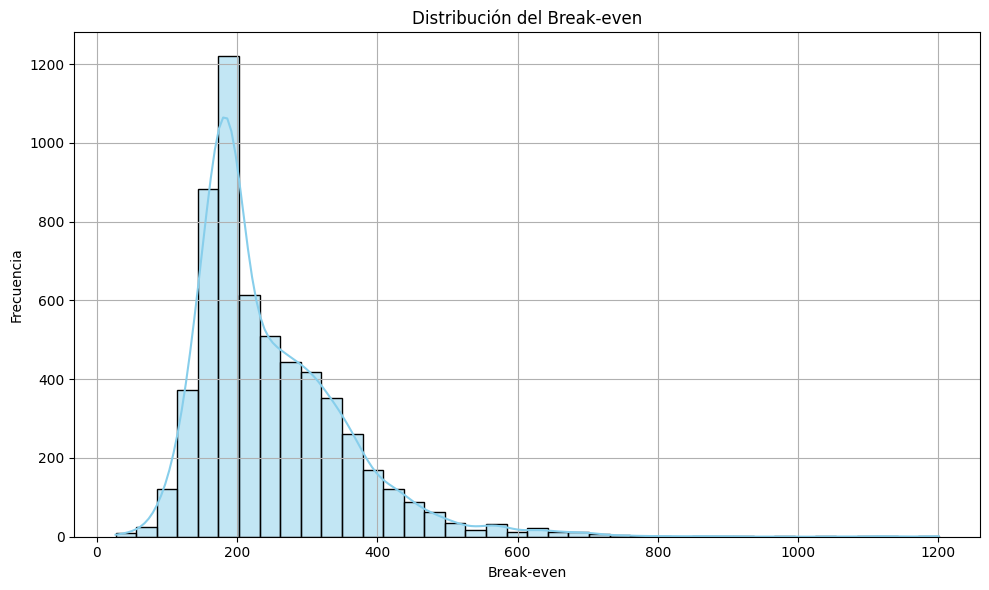

In [ ]:
plt.figure(figsize=(10, 6))

# Filtrar valores menores o iguales a 2000
break_even_filtrado = xgboost_data[xgboost_data["break_even_m2"] <= 2000]["break_even_m2"]

sns.histplot(break_even_filtrado, kde=True, bins=40, color='skyblue', edgecolor='black')
plt.title("Distribución del Break-even")
plt.xlabel("Break-even")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

La distribución del break-even  muestra que la mayoría de las viviendas presentan un periodo de recuperación de la inversión cercano a los 200 meses. Esta concentración indica que, en términos generales, se necesitarían aproximadamente 16-17 años de alquiler para recuperar el coste de adquisición del inmueble. Aunque existen casos con valores significativamente superiores, estos representan una minoría y pueden considerarse atípicos dentro del mercado analizado.

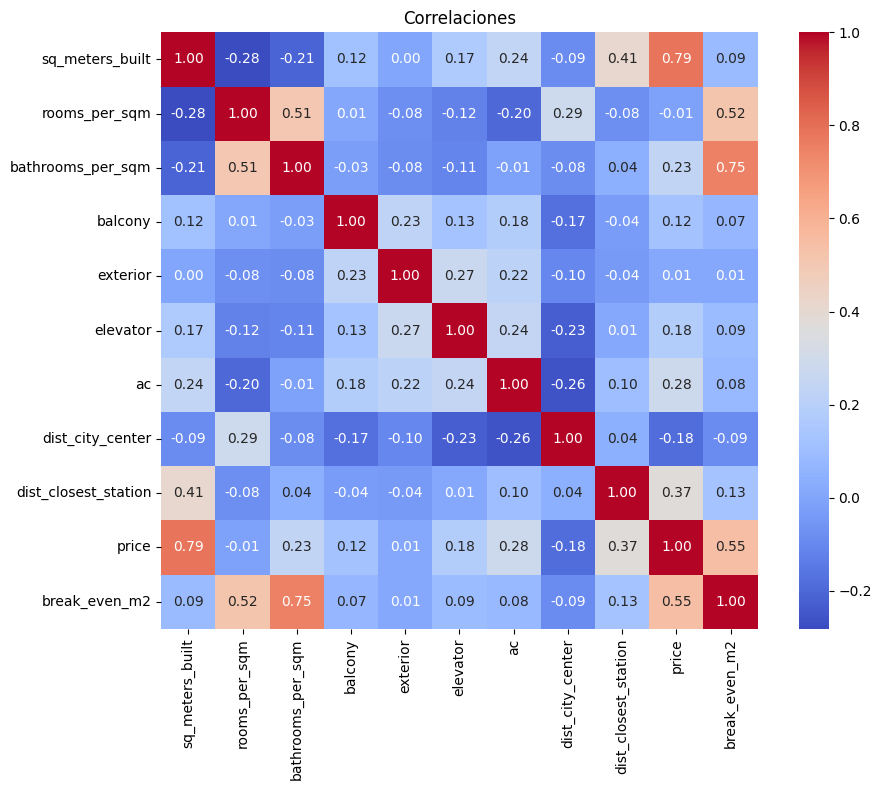

In [111]:
# Variables a excluir del mapa
vars_excluir = ["alquiler_estimado", "precio_m2", "alquiler_m2", "break_even_meses"]

# Filtramos solo las columnas numéricas que no estén en la lista de exclusión
columnas_corr = [col for col in xgboost_data.select_dtypes(include="number").columns if col not in vars_excluir]

# Calculamos la matriz de correlación
corr_matrix = xgboost_data[columnas_corr].corr()

# Graficamos
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlaciones")
plt.tight_layout()
plt.show()


En el análisis de correlaciones, destacan las variables price, bathrooms_per_sqm y rooms_per_sqm por mostrar una correlación positiva moderada con break_even. Esto sugiere que el precio total del inmueble, así como la densidad de estancias por metro cuadrado, podrian influir de forma relevante en el tiempo estimado para recuperar la inversión. Destaca que no hay ninguna correlación con los metros cuadrados.

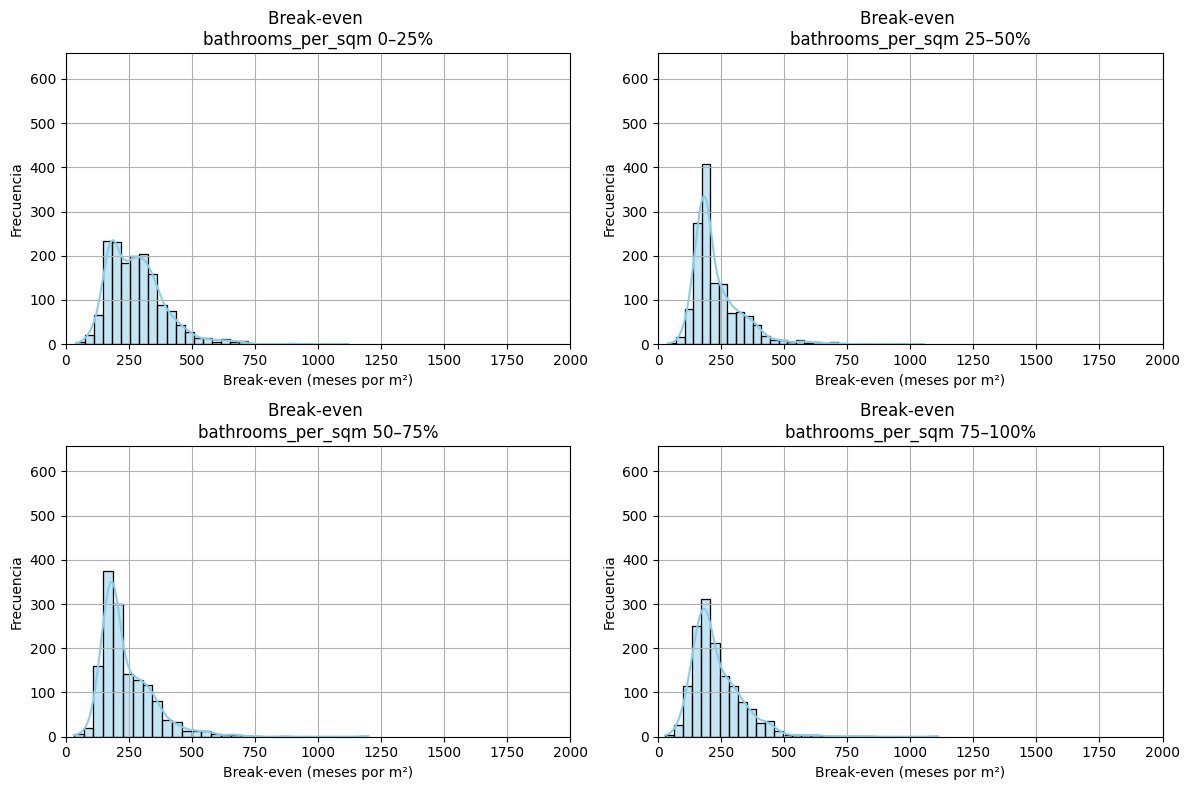

In [127]:
# Filtrar a valores menores o iguales a 2000
data_filtrada = xgboost_data[xgboost_data["break_even_m2"] <= 2000]

# Calcular los cuartiles de bathrooms_per_sqm
q1 = data_filtrada["bathrooms_per_sqm"].quantile(0.25)
q2 = data_filtrada["bathrooms_per_sqm"].quantile(0.50)
q3 = data_filtrada["bathrooms_per_sqm"].quantile(0.75)

# Crear rangos y etiquetas
rangos = [
    (data_filtrada["bathrooms_per_sqm"] <= q1, "0–25%"),
    ((data_filtrada["bathrooms_per_sqm"] > q1) & (data_filtrada["bathrooms_per_sqm"] <= q2), "25–50%"),
    ((data_filtrada["bathrooms_per_sqm"] > q2) & (data_filtrada["bathrooms_per_sqm"] <= q3), "50–75%"),
    (data_filtrada["bathrooms_per_sqm"] > q3, "75–100%")
]

# Calcular el valor máximo de frecuencia para igualar el eje Y
max_freq = 0
for filtro, _ in rangos:
    subset = data_filtrada[filtro]["break_even_m2"]
    counts, _ = np.histogram(subset, bins=30, range=(0, 2000))
    max_freq = max(max_freq, counts.max())

# Crear subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Graficar en cada subplot
for i, (filtro, etiqueta) in enumerate(rangos):
    subset = data_filtrada[filtro]["break_even_m2"]
    sns.histplot(subset, kde=True, bins=30, color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f"Break-even \nbathrooms_per_sqm {etiqueta}")
    axes[i].set_xlabel("Break-even (meses por m²)")
    axes[i].set_ylabel("Frecuencia")
    axes[i].set_xlim(0, 2000)
    axes[i].set_ylim(0, max_freq + 10)  # margen para que no corte
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Al analizar la distribución del break-even por metro cuadrado segmentado por cuartiles de la variable bathrooms_per_sqm, no se observan diferencias sustanciales entre los grupos. En los cuatro tramos, las distribuciones presentan una forma similar, con concentraciones en torno a los 200–300 meses y una ligera asimetría a la derecha. Esta similitud sugiere que, al menos de forma individual, bathrooms_per_sqm no discrimina significativamente el perfil de viviendas más rentables.

In [ ]:
# Regresión lineal

# Variables predictoras
features = [
    'rooms_per_sqm',
    'bathrooms_per_sqm',
    'dist_city_center',
    'balcony',
    'exterior',
    'elevator',
    'ac'
]

X = xgboost_data[features]
y = xgboost_data["break_even_m2"]

# Añadir constante para el intercepto
X = sm.add_constant(X)

# Ajustar el modelo de regresión
modelo = sm.OLS(y, X).fit()

# Mostrar el resumen
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:          break_even_m2   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     1448.
Date:                Tue, 08 Jul 2025   Prob (F-statistic):               0.00
Time:                        03:45:33   Log-Likelihood:                -39778.
No. Observations:                5847   AIC:                         7.957e+04
Df Residuals:                    5839   BIC:                         7.962e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -337.3833     10.70

El modelo de regresión lineal explica el 63,4% de la variabilidad del break-even por metro cuadrado, lo que sugiere una capacidad explicativa razonablemente sólida. Entre las variables que más contribuyen a incrementar el número de meses necesarios para recuperar la inversión (es decir, a reducir la rentabilidad), destacan bathrooms_per_sqm y elevator, con coeficientes positivos de 194,23 y 110,03 respectivamente. Esto indica que viviendas con una mayor densidad de baños o que cuentan con ascensor tienden, en promedio, a ser menos rentables.